In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [282]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler


In [3]:
warnings.filterwarnings('ignore')

In [4]:
data= pd.read_csv('train.csv')

# Exploratory Data Analysis

## Handling Missing Values

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
# Less than 50%  of the rows have these variables populated, hence they can be omitted from our analysis 
drop_list= ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu']
data.drop(drop_list, axis= 1, inplace= True)

In [7]:
# Doing a row wise analysis for missing data
# Maximum 13% of the variables can be missing, hence it does not justify dropping any rows
null_val_row= data.isnull().sum(axis= 1).to_frame(name= 'null_count') 
null_val_row['perc_null']= null_val_row.null_count.apply(lambda x: 100*(round((x/len(data.columns)),2)))
null_val_row.sort_values(by= 'perc_null', ascending= False)

,null_count,perc_null
1179,10,13.0
705,10,13.0
1011,10,13.0
520,10,13.0
1218,10,13.0
...,...,...
554,0,0.0
552,0,0.0
551,0,0.0
550,0,0.0


In [8]:
#Checking for null values in variables
data.isnull().sum().sort_values(ascending= False).head(20)

LotFrontage     259
GarageFinish     81
GarageType       81
GarageCond       81
GarageQual       81
GarageYrBlt      81
BsmtExposure     38
BsmtFinType2     38
BsmtFinType1     37
BsmtCond         37
BsmtQual         37
MasVnrType        8
MasVnrArea        8
Electrical        1
RoofStyle         0
RoofMatl          0
SalePrice         0
Exterior1st       0
Exterior2nd       0
YearBuilt         0
dtype: int64

In [9]:
# Creating a List of the missing values
missing_var= ['LotFrontage', 'GarageFinish','GarageType', 'GarageCond', 'GarageQual', 'GarageYrBlt', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'MasVnrType', 'MasVnrArea', 'Electrical']

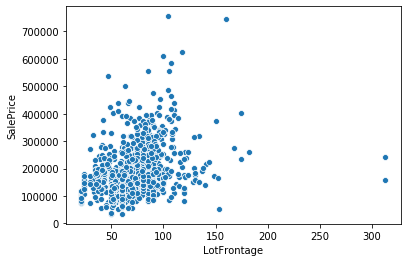

In [10]:
# Investigating the variable 'LotFrontage'
# LotFrontage: Linear feet of street connected to property
# scatterplot of 'LotFrontage' vs 'SalePrice'

sns.scatterplot(data.LotFrontage, data.SalePrice)

In [11]:
# General description of 'LotFrontage' variable
data.LotFrontage.describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [12]:
# Median value of 'LotFrontage' variable
data.LotFrontage.median()

69.0

In [13]:
# Modal value of 'LotFrontage' variable
data.LotFrontage.mode()[0]

60.0

In [14]:
# Creating a dictionary 'dict_LotFrontage' to compute the change in 'mean','median' and 'mode' after imputing the missing values
# with current 'mean','median' and 'mode' values

Values= {'Mean': 70.05, 'Median': 69.0, 'Mode': 60.0}
dict_LotFrontage= {'original': [70, 69, 60]}
for i in Values:
    data_new= data.LotFrontage.fillna(Values['{0}'.format(i)])
    dict_LotFrontage.update({'{0} (% change)'.format(i): [100*round((data_new.mean()- 70.05)/70.05,3),100*round((data_new.median()-69)/69,3),100*round((data_new.mode()[0]-60)/60,3)]})

In [15]:
# Converting it to a DataFrame for better understangeing
Change_LotFrontage= pd.DataFrame(dict_LotFrontage, index= ['mean', 'median', 'mode'])
Change_LotFrontage

,original,Mean (% change),Median (% change),Mode (% change)
mean,70,-0.0,-0.3,-2.5
median,69,1.5,0.0,-8.7
mode,60,16.7,15.0,0.0


In [16]:
# Clearly imputing it with the mode causes the least amount of change to the 'mean', 'median' and 'mode' of the variable
# Hence imputing the missing values with the modal value is most suitable
data.LotFrontage.fillna(value= 60.0, inplace= True)

In [17]:
data.LotFrontage.isnull().sum()

0

In [18]:
# Checking the value counts for the variable 'GarageFinish'
data.GarageFinish.value_counts()

Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

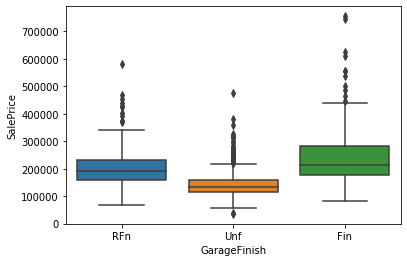

In [19]:
# Boxplot for 'SalePrice' vs 'GarageFinish'
sns.boxplot(data.GarageFinish, data.SalePrice)

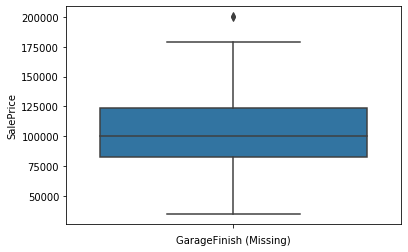

In [20]:
# Boxplot for the 'SalePrice' of the values in which 'GarageFinish' is missing
# The median of these values are 100000
plt.xlabel('GarageFinish (Missing)')
sns.boxplot(y= data.loc[data.GarageFinish.isnull()]['SalePrice'])

In [21]:
# The value with median price closest to 100000 is 'Unf' which also happens to be the modal value for 'GarageFinish'
# Hence it is safe to impute it with 'Unf'
data.GarageFinish.fillna('Unf',inplace= True)

In [22]:
# Checking the null values in 'GarageFinish'
data.GarageFinish.isnull().sum()

0

In [23]:
# Checking the value counts for the variable 'GarageType'
data.GarageType.value_counts()

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

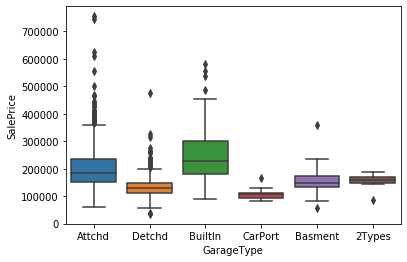

In [24]:
# Boxplot for 'SalePrice' vs 'GarageType'
sns.boxplot(data.GarageType, data.SalePrice)

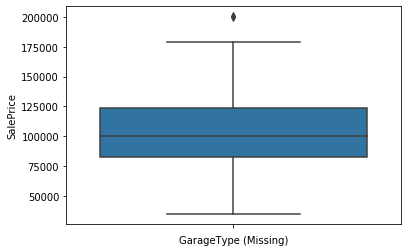

In [25]:
# Boxplot for the 'SalePrice' of the values in which 'GarageType' is missing
# The median of these values are 100000
plt.xlabel('GarageType (Missing)')
sns.boxplot(y= data.loc[data.GarageType.isnull()]['SalePrice'])

In [26]:
# The value with median price closest to 100000 is 'Detchd'
# Hence it is safe to impute it with 'Detchd' and checking the value count
data.GarageType.fillna('Detchd',inplace= True)
data.GarageType.isnull().sum()

0

In [27]:
# Checking the value counts for the variable 'GarageCond'
GarageCond= data.GarageCond.value_counts(normalize= True).to_frame(name= 'norm_val')
GarageCond['perc_val']= GarageCond.norm_val.apply(lambda x: 100*round(x,2) )
GarageCond

,norm_val,perc_val
TA,0.961566,96.0
Fa,0.025381,3.0
Gd,0.006526,1.0
Po,0.005076,1.0
Ex,0.001450,0.0


In [28]:
# 96% of the values for the variable ' GarageCond' have the value 'TA'
# Hence the entire variable can be safely dropped from our analysis
data.drop('GarageCond', axis= 1, inplace= True)

In [29]:
# Checking the value counts for the variable 'GarageQual'
GarageQual= data.GarageQual.value_counts(normalize= True).to_frame(name= 'norm_val')
GarageQual['perc_val']= GarageQual.norm_val.apply(lambda x: 100*round(x,2) )
GarageQual

,norm_val,perc_val
TA,0.950689,95.0
Fa,0.034808,3.0
Gd,0.010152,1.0
Po,0.002175,0.0
Ex,0.002175,0.0


In [30]:
# 95% of the values are 'TA', hence it is safe to drop this variable from our analysis
data.drop('GarageQual', axis= 1, inplace= True)

In [31]:
# Value count for 'BsmtExposure' variable
data.BsmtExposure.value_counts()

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

In [32]:
# Checking the normalized and percentage values for variable 'BsmtExposure'
# 67 % of the values are 'No'
BsmtExposure= data.BsmtExposure.value_counts(normalize= True).to_frame(name= 'norm_val')
BsmtExposure['perc_val']= BsmtExposure.norm_val.apply(lambda x: 100*round(x,2) )
BsmtExposure

,norm_val,perc_val
No,0.670183,67.0
Av,0.155415,16.0
Gd,0.094233,9.0
Mn,0.080169,8.0


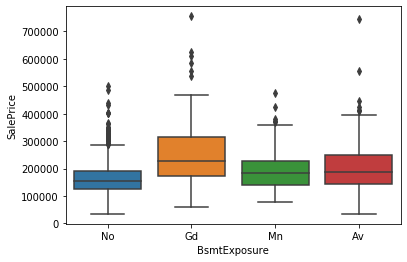

In [33]:
# Boxplot for 'SalePrice' vs 'BsmtExposure'
sns.boxplot(data.BsmtExposure, data.SalePrice)

In [34]:
# Median Sales value for the missing data
data.loc[data.BsmtExposure.isnull()]['SalePrice'].median()

104025.0

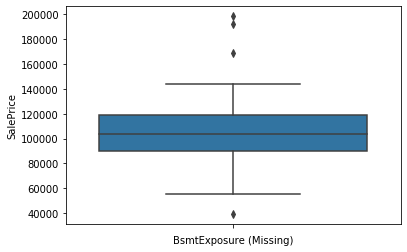

In [35]:
# Boxplot for 'SalePrice' vs 'BsmtExposure' for missing values
plt.xlabel('BsmtExposure (Missing)')
sns.boxplot(y= data.loc[data.BsmtExposure.isnull()]['SalePrice'])

In [36]:
# The median value for the missing values is closest to the value 'No' which also happens to be the modal value
# Hence it is safe to impute the missing values with 'No'
data.BsmtExposure.fillna('No', inplace= True)
data.BsmtExposure.value_counts()

No    991
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

In [37]:
data.BsmtExposure.isnull().sum()

0

In [38]:
# Checking the normalized and percentage values for the variable 'BsmtFinType2'
BsmtFinType2= data.BsmtFinType2.value_counts(normalize= True).to_frame(name= 'norm_val')
BsmtFinType2['perc_val']= BsmtFinType2.norm_val.apply(lambda x: 100*round(x,2) )
BsmtFinType2

,norm_val,perc_val
Unf,0.883263,88.0
Rec,0.037975,4.0
LwQ,0.032349,3.0
BLQ,0.023207,2.0
ALQ,0.013361,1.0
GLQ,0.009845,1.0


In [39]:
# 88% of the values are 'Unf' hence we can drop this variable from our analysis
data.drop('BsmtFinType2', axis= 1, inplace= True)

In [40]:
# Checking the normalized and percentage values for the variable 'BsmtFinType1'
BsmtFinType1= data.BsmtFinType1.value_counts(normalize= True).to_frame(name= 'norm_val')
BsmtFinType1['perc_val']= BsmtFinType1.norm_val.apply(lambda x: 100*round(x,2) )
BsmtFinType1

,norm_val,perc_val
Unf,0.302178,30.0
GLQ,0.293746,29.0
ALQ,0.154603,15.0
BLQ,0.104006,10.0
Rec,0.093465,9.0
LwQ,0.052003,5.0


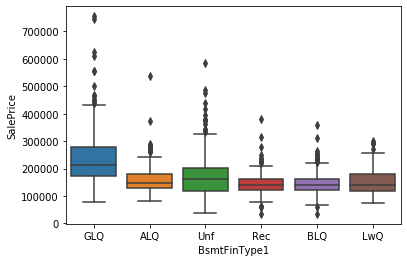

In [41]:
# Boxplot for 'SalePrice' vs 'BsmtFinType1'
sns.boxplot(y= data.SalePrice, x= data.BsmtFinType1)

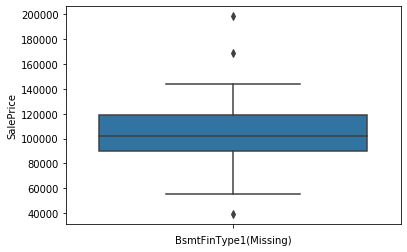

In [42]:
# Boxplot for 'SalePrice' vs 'BsmtFinType1' for missing data
plt.xlabel('BsmtFinType1(Missing)')
sns.boxplot(y= data.loc[data['BsmtFinType1'].isnull()]['SalePrice'])

In [43]:
# The median sale data for the missing values is 100000
# This is close to the median data for the value 'Unf' which is also the modal value
# Hence we can impute the missing values with 'Unf'
data.BsmtFinType1.fillna(value= 'Unf', inplace= True)
data.BsmtFinType1.value_counts()

Unf    467
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

In [44]:
data.BsmtFinType1.isnull().sum()

0

In [45]:
# Checking the normalized and percentage values for the variable 'BsmtCond'
BsmtCond= data.BsmtCond.value_counts(normalize= True).to_frame(name= 'norm_val')
BsmtCond['perc_val']= BsmtCond.norm_val.apply(lambda x: 100*round(x,2) )
BsmtCond

,norm_val,perc_val
TA,0.921293,92.0
Gd,0.045678,5.0
Fa,0.031623,3.0
Po,0.001405,0.0


In [46]:
# 92% of the values for the variable 'BsmtCond' are 'TA'
# Hence we can drop it from our analysis

data.drop('BsmtCond', axis= 1, inplace= True)

In [47]:
# Checking the normalized and percentage values for the variable 'BsmtQual'
BsmtQual= data.BsmtQual.value_counts(normalize= True).to_frame(name= 'norm_val')
BsmtQual['perc_val']= BsmtQual.norm_val.apply(lambda x: 100*round(x,2) )
BsmtQual

,norm_val,perc_val
TA,0.456079,46.0
Gd,0.434294,43.0
Ex,0.085032,9.0
Fa,0.024596,2.0


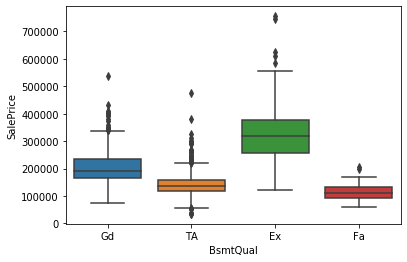

In [48]:
# Boxplot for 'SalePrice' vs 'BsmtQual'
sns.boxplot(y= data.SalePrice, x= data.BsmtQual)

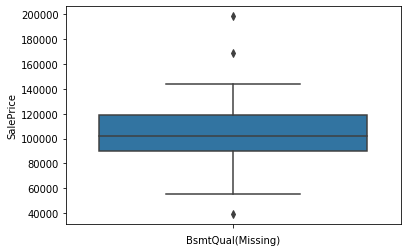

In [49]:
# Boxplot for 'SalePrice' vs 'BsmtQual' for missing data
plt.xlabel('BsmtQual(Missing)')
sns.boxplot(y= data.loc[data['BsmtQual'].isnull()]['SalePrice'])

In [50]:
# The median sale data for the missing values is 100000
# This is close to the median data for the value 'TA' which is also the modal value
# Hence we can impute the missing values with 'TA'
data.BsmtQual.fillna(value= 'TA', inplace= True)
data.BsmtQual.isnull().sum()

0

In [51]:
# For the variables 'MasVnrArea' and 'MasVnrType' we will impute the modal values as the number of missing values are very small
# and can be safely imputed with the modal value
# For 'MasVnrArea'
data.MasVnrArea.value_counts(normalize= True)

0.0      0.592975
72.0     0.005510
180.0    0.005510
108.0    0.005510
120.0    0.004821
           ...   
651.0    0.000689
337.0    0.000689
415.0    0.000689
293.0    0.000689
621.0    0.000689
Name: MasVnrArea, Length: 327, dtype: float64

In [52]:
# For 'MasVnrType'
data.MasVnrType.value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [53]:
# Imputing the values '0.0' and 'None' for 'MasVnrArea' and ' MasVnrType' respectively
data.MasVnrArea.fillna(0.0, inplace= True)
data.MasVnrType.fillna('None', inplace= True)

In [54]:
# Checking null values for 'MasVnrArea'
data.MasVnrArea.isnull().sum()

0

In [55]:
# Checking null values for 'MasVnrType'
data.MasVnrType.isnull().sum()

0

In [56]:
# Checking the normalized and percentage values for the variable 'Electrical'
Electrical= data.Electrical.value_counts(normalize= True).to_frame(name= 'norm_val')
Electrical['perc_val']= Electrical.norm_val.apply(lambda x: 100*round(x,2) )
Electrical

,norm_val,perc_val
SBrkr,0.914325,91.0
FuseA,0.064428,6.0
FuseF,0.018506,2.0
FuseP,0.002056,0.0
Mix,0.000685,0.0


In [57]:
# 91% of the values are 'SBrkr' hence we can drop this variable from our analysis
data.drop('Electrical', axis= 1, inplace= True)

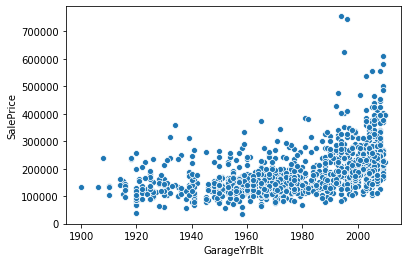

In [58]:
# Scatterplot for 'SalePrice' vs 'GarageYrBlt'
sns.scatterplot(data.GarageYrBlt, data.SalePrice)

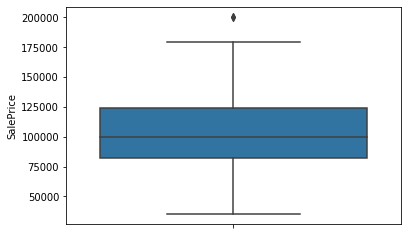

In [59]:
# Boxplot for 'SalePrice' vs 'GarageYrBlt' for the missing data

sns.boxplot(y= data.loc[data.GarageYrBlt.isnull()]['SalePrice'])

In [60]:
# Median for the variable GarageYrBlt
data.GarageYrBlt.median()

1980.0

In [61]:
# Mean for the variable GarageYrBlt
# It is safe to assume the mean and median year are the same '1980'
round(data.GarageYrBlt.mean(), 0)

1979.0

In [62]:
# Creating a DataFrame to better visualize the missing data
modal_year= [data.loc[data.GarageYrBlt== 2005]['SalePrice'].mean(), data.loc[data.GarageYrBlt== 2005]['SalePrice'].median()]
median_year= [data.loc[data.GarageYrBlt== 1980]['SalePrice'].mean(), data.loc[data.GarageYrBlt== 1980]['SalePrice'].median()]
missing_year=[data.loc[data.GarageYrBlt.isnull()]['SalePrice'].mean(), data.loc[data.GarageYrBlt.isnull()]['SalePrice'].median()]

In [63]:
# DataFrame for 'GarageYrBlt' missing data visualization
df_year= pd.DataFrame({'Missing':missing_year, 'Median': median_year, 'Modal': modal_year}, index= ['Mean', 'Median'])
df_year

,Missing,Median,Modal
Mean,103317.283951,141376.666667,217894.261538
Median,100000.000000,140000.000000,192500.000000


In [64]:
# The data values for the Median year is closest to our missing data 
# Imputing the missing data with the Median year '1980' would hence be the safest choice

data.GarageYrBlt.fillna(1980, inplace= True)

In [65]:
# Checking out main DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 71 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [66]:
# Rechecking for null values
data.isnull().sum().sort_values(ascending= False)

SalePrice       0
MasVnrArea      0
YearRemodAdd    0
RoofStyle       0
RoofMatl        0
               ..
BedroomAbvGr    0
KitchenAbvGr    0
KitchenQual     0
TotRmsAbvGrd    0
Id              0
Length: 71, dtype: int64

In [67]:
# These are all the numerical variables
Numerical= ['SalePrice','LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF','2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF']

In [68]:
# These are all the categorical variables
Categorical= ['LotShape','LotConfig', 'Neighborhood', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond','YearBuilt', 'YearRemodAdd', 'RoofStyle','Exterior1st', 'Exterior2nd','MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure','BsmtFinType1', 'HeatingQC','BsmtFullBath','FullBath','HalfBath','BedroomAbvGr','KitchenQual','TotRmsAbvGrd','Fireplaces','GarageType','GarageYrBlt','GarageFinish', 'GarageCars','MoSold','YrSold','SaleCondition']

In [69]:
# In these variable 85 % or more of the datapoints are populated by a single value, hence they are not good predictors as they
# are essentially the same for the entire data set
# Hence we can drop these variables

Drop= ['Street', 'LandContour', 'Utilities','LandSlope', 'Condition1','Condition2', 'RoofMatl', 'ExterCond','BsmtFinSF2', 'Heating', 'CentralAir','LowQualFinSF', 'BsmtHalfBath','KitchenAbvGr','Functional','PavedDrive','EnclosedPorch', '3SsnPorch','ScreenPorch','PoolArea','MiscVal','SaleType' ]
data.drop(Drop, axis= 1, inplace = True)

## Numerical Data (Visualization ,Data Cleaning and Formatting)

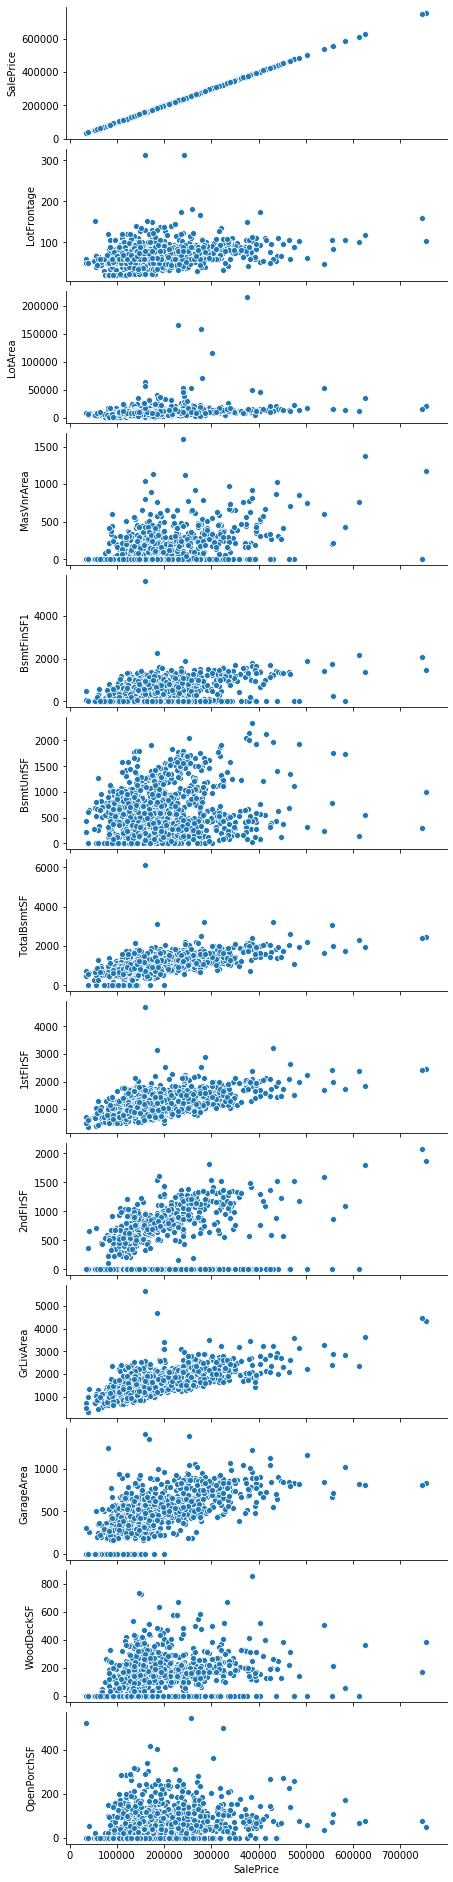

In [70]:
# Visualization of the Numerical data
sns.pairplot(y_vars= Numerical, x_vars= 'SalePrice', data= data, height= 2, aspect = 3)

In [71]:
# Creating a function to convert binary variables to '0' and '1'
# the function takes two variables 'x' and 'y'
# whenever x==y it returns '0' else it returns '1'
def binary_conv(x,y):
        if x==y:
            return 0
        else:
            return 1


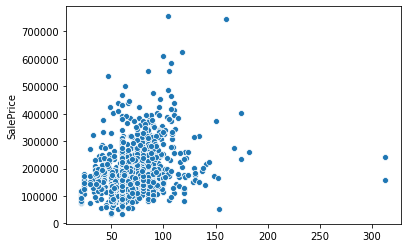

In [72]:
# Scatterplot for 'LotFrontage' vs 'SalePrice'
sns.scatterplot(data.LotFrontage.values, data.SalePrice)

In [73]:
# Creating a DataFrame to better understand the values in the variable 'LotFrontage'
# it is obvious that this variable is dominated by the value '60' which consists of 27% of the variable
# the other values make up less than 5% each
LotFrontage= data.LotFrontage.value_counts(normalize= True).to_frame(name= 'norm_val')
LotFrontage.reset_index(inplace= True)
LotFrontage.rename(columns= {'index': 'LotFrontage'}, inplace= True)
LotFrontage.sort_values(by= 'norm_val', ascending= False).head(10)

,LotFrontage,norm_val
0,60.0,0.275342
1,70.0,0.047945
2,80.0,0.047260
3,50.0,0.039041
4,75.0,0.036301
5,65.0,0.030137
6,85.0,0.027397
7,78.0,0.017123
8,21.0,0.015753
9,90.0,0.015753


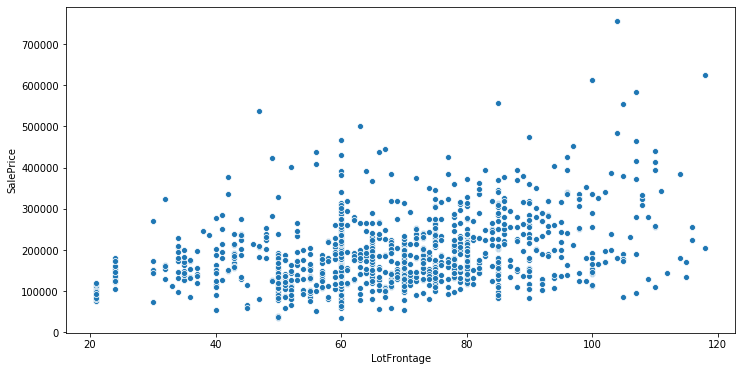

In [74]:
# On viewing the plot on a larger frame it is obvious that there is 
# no trend between 'LotFrontage' and 'SalePrice'
# also there is alot of variance
plt.figure(figsize= (12,6))
sns.scatterplot(data.loc[data.LotFrontage < 120].LotFrontage, data.SalePrice)

In [75]:
# Due to the above factors dropping the variable is our best option
data.drop('LotFrontage', axis= 1, inplace= True)

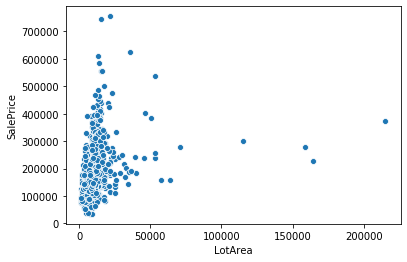

In [76]:
# Scatterplot for 'LotArea' vs 'SalePrice'
sns.scatterplot(data.LotArea, data.SalePrice)

In [77]:
# Creating a DataFrame for 'LotArea' values
LotArea = data.LotArea.value_counts(normalize= True).to_frame(name= 'norm_val')
LotArea.reset_index(inplace= True)
LotArea.rename(columns= {'index': 'LotArea'}, inplace= True)
LotArea.sort_values(by= 'norm_val', ascending= False).head(10)

,LotArea,norm_val
0,7200,0.017123
1,9600,0.016438
2,6000,0.011644
3,10800,0.009589
4,9000,0.009589
5,8400,0.009589
6,1680,0.006849
7,7500,0.006164
10,6120,0.005479
11,6240,0.005479


In [78]:
# 'LotArea' in '20' interval bins
data.LotArea.value_counts(bins= 20).sort_index(ascending= True)

(1086.054, 11997.25]     1139
(11997.25, 22694.5]       284
(22694.5, 33391.75]        18
(33391.75, 44089.0]         6
(44089.0, 54786.25]         6
(54786.25, 65483.5]         2
(65483.5, 76180.75]         1
(76180.75, 86878.0]         0
(86878.0, 97575.25]         0
(97575.25, 108272.5]        0
(108272.5, 118969.75]       1
(118969.75, 129667.0]       0
(129667.0, 140364.25]       0
(140364.25, 151061.5]       0
(151061.5, 161758.75]       1
(161758.75, 172456.0]       1
(172456.0, 183153.25]       0
(183153.25, 193850.5]       0
(193850.5, 204547.75]       0
(204547.75, 215245.0]       1
Name: LotArea, dtype: int64

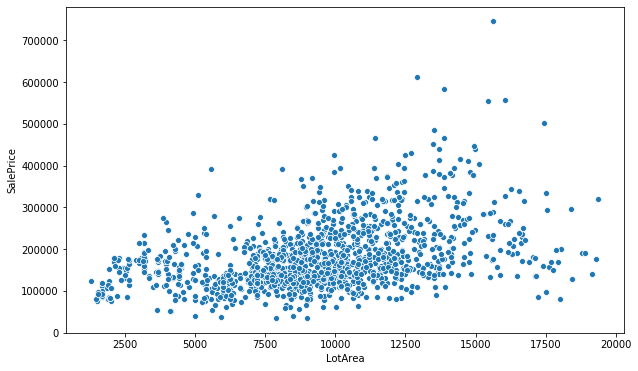

In [79]:
# Larger Scatterplot for better Visualization
plt.figure(figsize= (10,6))
sns.scatterplot(data.loc[data.LotArea <19500].LotArea, data.SalePrice)

In [80]:
# Since there is no trend in the price 'LotArea' is not a good predictor
# Dropping it from our analysis
data.drop('LotArea', axis= 1, inplace= True)

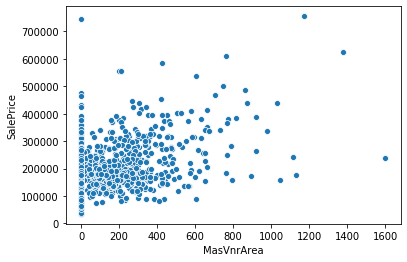

In [81]:
# scatterplot for 'MasVnrArea' vs 'SalePrice'
sns.scatterplot(data.MasVnrArea, data.SalePrice)

In [82]:
# 'MasVnrArea' values in '10' interval bins
data.MasVnrArea.value_counts(bins= 10)

(-1.601, 160.0]     1089
(160.0, 320.0]       220
(320.0, 480.0]        91
(480.0, 640.0]        28
(640.0, 800.0]        18
(800.0, 960.0]         6
(960.0, 1120.0]        4
(1120.0, 1280.0]       2
(1440.0, 1600.0]       1
(1280.0, 1440.0]       1
Name: MasVnrArea, dtype: int64

In [83]:
# Normalized value counts for values
# Clearly dominated by the value '0'
data.MasVnrArea.value_counts(normalize= True).sort_values(ascending= False)

0.0      0.595205
72.0     0.005479
180.0    0.005479
108.0    0.005479
120.0    0.004795
           ...   
603.0    0.000685
748.0    0.000685
459.0    0.000685
506.0    0.000685
67.0     0.000685
Name: MasVnrArea, Length: 327, dtype: float64

In [84]:
# since 'MasVnrArea' dominated by a single value and there is no trend when we plot it against Price
# we can drop 'MasVnrArea' from our analysis
data.drop('MasVnrArea', axis= 1, inplace= True)

In [85]:
# Checking the no. of rows in our master DataFrame
len(data.index)

1460

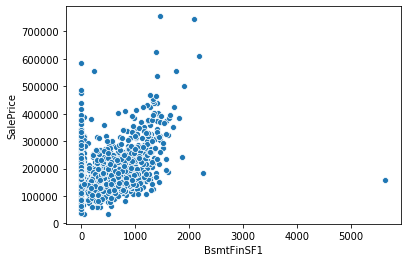

In [86]:
# Scatterplot for 'BsmtFinSF1' vs 'SalePrice'
sns.scatterplot(data.BsmtFinSF1, data.SalePrice)

In [87]:
# Value counts for 'BsmtFinSF1'
data.BsmtFinSF1.value_counts().sort_index(ascending= True).head(10)

0     467
2       1
16      9
20      5
24     12
25      1
27      1
28      3
33      1
35      1
Name: BsmtFinSF1, dtype: int64

In [88]:
# values in '10' interval bins
data.BsmtFinSF1.value_counts(bins=84).sort_values(ascending= False).head(10)

(-5.6450000000000005, 67.19]    515
(604.714, 671.905]               83
(335.952, 403.143]               79
(537.524, 604.714]               79
(671.905, 739.095]               74
(470.333, 537.524]               65
(403.143, 470.333]               64
(268.762, 335.952]               58
(201.571, 268.762]               48
(739.095, 806.286]               47
Name: BsmtFinSF1, dtype: int64

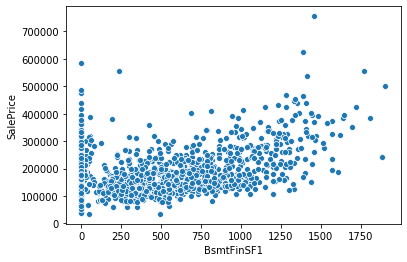

In [89]:
# Scatterplot after removing obvious outliers
sns.scatterplot(data.loc[data.BsmtFinSF1 < 2000].BsmtFinSF1, data.SalePrice)

In [90]:
# There is no trend in the above plot 
# also the variable is dominated by one value
# Dropping 'BsmtFinSF1' from our analysis
data.drop('BsmtFinSF1', axis= 1, inplace= True)

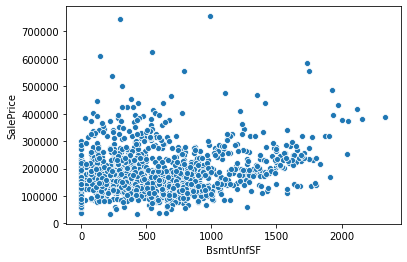

In [91]:
#Scatterplot for 'BsmtUnfSF' vs 'SalePrice'
sns.scatterplot(data.BsmtUnfSF, data.SalePrice)

In [92]:
# Normalized values for 'BsmtUnfSF'
# Heavily dominated by one value
data.BsmtUnfSF.value_counts(normalize= True).sort_values(ascending= False).head(5)

0      0.080822
728    0.006164
384    0.005479
572    0.004795
600    0.004795
Name: BsmtUnfSF, dtype: float64

In [93]:
# values in 10 interval bins
data.BsmtUnfSF.value_counts(bins= 10).sort_index(ascending= True)

(-2.3369999999999997, 233.6]    375
(233.6, 467.2]                  346
(467.2, 700.8]                  256
(700.8, 934.4]                  216
(934.4, 1168.0]                 106
(1168.0, 1401.6]                 72
(1401.6, 1635.2]                 53
(1635.2, 1868.8]                 24
(1868.8, 2102.4]                  9
(2102.4, 2336.0]                  3
Name: BsmtUnfSF, dtype: int64

In [94]:
# since it is dominated by one value and there is not trend in the price
# we may drop 'BsmtUnfSF' from our analysis
data.drop('BsmtUnfSF', axis= 1, inplace= True)

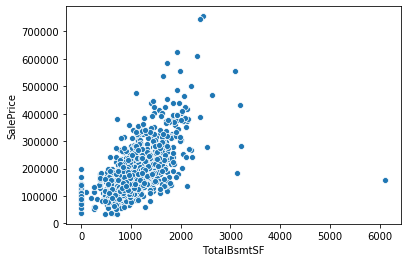

In [95]:
# Scatterplot for 'TotalBsmtSF' vs 'SalePrice'
sns.scatterplot(data.TotalBsmtSF, data.SalePrice)

In [96]:
# values in 20 interval bins
# the variable is well distributed and continuous
data.TotalBsmtSF.value_counts(bins= 20).sort_index(ascending= True)

(-6.111000000000001, 305.5]     44
(305.5, 611.0]                  78
(611.0, 916.5]                 486
(916.5, 1222.0]                420
(1222.0, 1527.5]               243
(1527.5, 1833.0]               130
(1833.0, 2138.5]                43
(2138.5, 2444.0]                 9
(2444.0, 2749.5]                 2
(2749.5, 3055.0]                 0
(3055.0, 3360.5]                 4
(3360.5, 3666.0]                 0
(3666.0, 3971.5]                 0
(3971.5, 4277.0]                 0
(4277.0, 4582.5]                 0
(4582.5, 4888.0]                 0
(4888.0, 5193.5]                 0
(5193.5, 5499.0]                 0
(5499.0, 5804.5]                 0
(5804.5, 6110.0]                 1
Name: TotalBsmtSF, dtype: int64

In [97]:
# Dropping outliers
data.drop(data.loc[(data.TotalBsmtSF >2083)].index, axis= 0, inplace= True)

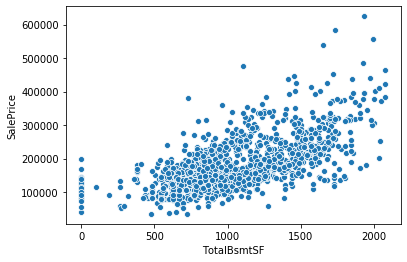

In [98]:
# visualizing data
sns.scatterplot(data.TotalBsmtSF, data.SalePrice)

In [99]:
# dropping outliers
data.drop(data.loc[data.SalePrice >500000].index, axis= 0, inplace= True)

In [100]:
# checking no. of data points in our master DataFrame
len(data.index)

1435

In [101]:
# Renaming the variable '1stFlrSF' to 'FirstFlrSF' to avoid any errors
# 1stFlrSF will produce an error if we try to access it with the dot operator
data.rename(columns= {'1stFlrSF': 'FirstFlrSF'}, inplace= True)

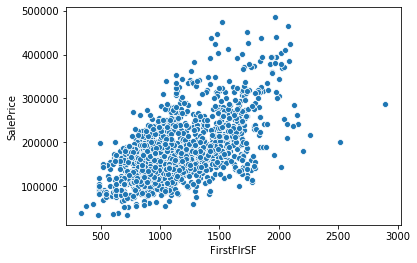

In [102]:
# Scatterplot for 'FirstFlrSF' vs 'SalePrice'
sns.scatterplot(data['FirstFlrSF'], data.SalePrice)

In [103]:
# Dropping outliers
data.drop(data.loc[data['FirstFlrSF'] >2400].index, axis= 0, inplace= True)

In [104]:
# Checking data points in master DataFrame
len(data.index)

1433

In [105]:
# Renaming the variable '2ndFlrSF' to 'SecondFlrSF' to avoid any errors
# 2ndFlrSF will produce an error if we try to access it with the dot operator
data.rename(columns= {'2ndFlrSF': 'SecondFlrSF'}, inplace= True)

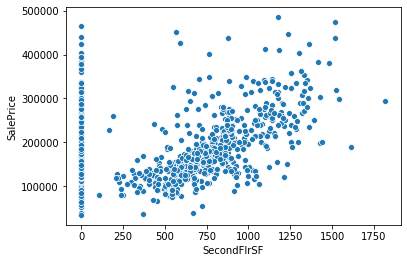

In [106]:
# Scatterplot for 'SecondFlrSF' vs 'SalePrice'
sns.scatterplot(data['SecondFlrSF'], data.SalePrice)

In [107]:
# The data is very heavily dominated by the value '0'
# counts for the value 0
data.loc[data['SecondFlrSF']==0].index.value_counts().sum()

811

In [108]:
# Dropping the variable 'SecondFlrSF' from our analysis
data.drop('SecondFlrSF', axis= 1, inplace = True)

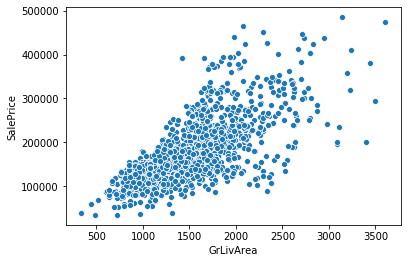

In [109]:
# Scatterplot for 'GrLivArea' vs 'SalePrice'
sns.scatterplot(data.GrLivArea, data.SalePrice)

In [110]:
# dropping outliers
data.drop(data.loc[data.GrLivArea > 3000].index, axis= 0, inplace= True)

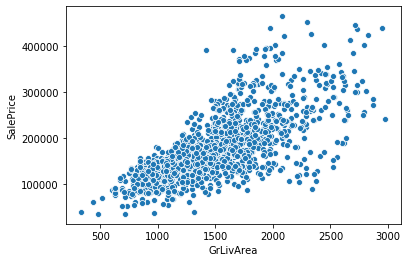

In [111]:
# visualizing data
sns.scatterplot(data.GrLivArea, data.SalePrice)

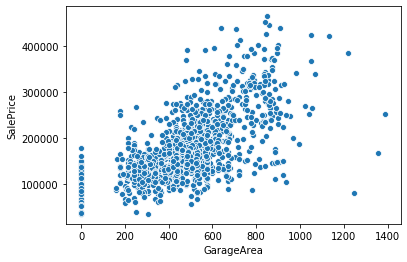

In [112]:
# Scatterplot for 'GarageArea' vs 'SalePrice'
sns.scatterplot(data.GarageArea, data.SalePrice)

In [113]:
# Checking the count for value '0'
# this is an acceptable value 
# also from the scatterplot 'GarageArea' looks to be a good predictor of price
data.loc[data.GarageArea==0].index.value_counts().sum()

79

In [114]:
# Dropping outliers
data.drop(data.loc[(data.GarageArea > 1000)].index, axis= 0, inplace= True)

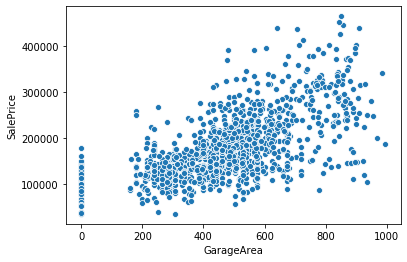

In [115]:
# visualizing data
sns.scatterplot(data.GarageArea, data.SalePrice)

In [116]:
len(data.index)

1411

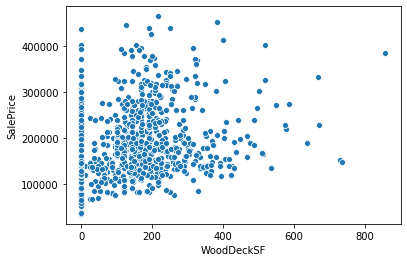

In [117]:
# Scatterplot for 'WoodDeckSF' vs 'SalePrice'
sns.scatterplot(data.WoodDeckSF, data.SalePrice)

In [118]:
# value count for '0'
data.loc[data.WoodDeckSF==0].index.value_counts().sum()

744

In [119]:
# this variable is heavily dominated by the value '0'
# there is no trend in the price 
# variance is very high, hence we may drop this variable
data.drop('WoodDeckSF', axis= 1, inplace= True)

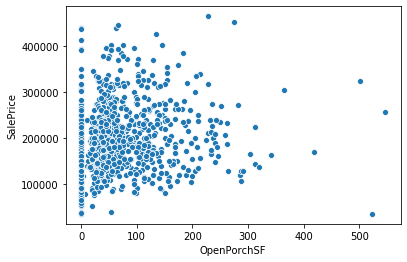

In [120]:
# Scatterplot for 'WoodDeckSF' vs 'SalePrice'
sns.scatterplot(data.OpenPorchSF, data.SalePrice)

In [121]:
# value count for '0'
data.loc[data.OpenPorchSF==0].index.value_counts().sum()

646

In [122]:
# this variable is heavily dominated by the value '0'
# there is no trend in the price 
# variance is very high, hence we may drop this variable
data.drop('OpenPorchSF', axis= 1, inplace= True)

In [123]:
# Checking datapoints in master DataFrame
len(data.index)

1411

In [124]:
# Updating Numerical variable list
Numerical= ['TotalBsmtSF', 'FirstFlrSF', 'GrLivArea', 'GarageArea']

In [125]:
# DataFrame of Numerical variables
data_num= data[Numerical]
data_num['SalePrice']= data['SalePrice']

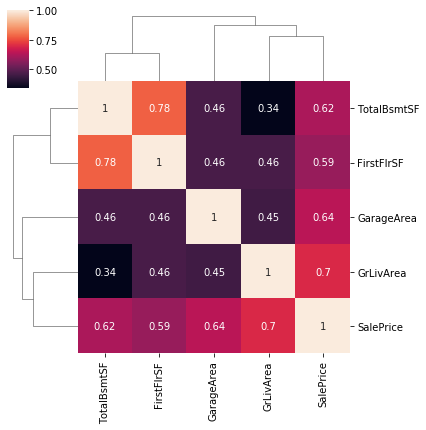

In [126]:
# Creating a cluster map to visualize the correlations
# Clearly all the selected variables have a strong influence on the price
sns.clustermap(data_num.corr(), annot= True, figsize=(6, 6))

## Categorical Variables (Mapping , Cleaning,Visualization and Formatting)

In [127]:
# Identifies the general zoning classification of the sale
# Clearly the variable values'RH', 'C (all)' can be dropped as they donot contribute significantly

Zoning= data.MSZoning.value_counts(normalize= True, sort= True).to_frame()
Zoning.reset_index(inplace= True)
Zoning.rename(columns= {'index': 'Zoning', 'MSZoning': 'normal_value'}, inplace= True)
Zoning['percentage']= Zoning['normal_value'].apply(lambda x: 100*round(x, 2)) 
Zoning

,Zoning,normal_value,percentage
0,RL,0.785967,79.0
1,RM,0.153083,15.0
2,FV,0.043940,4.0
3,RH,0.010631,1.0
4,C (all),0.006378,1.0


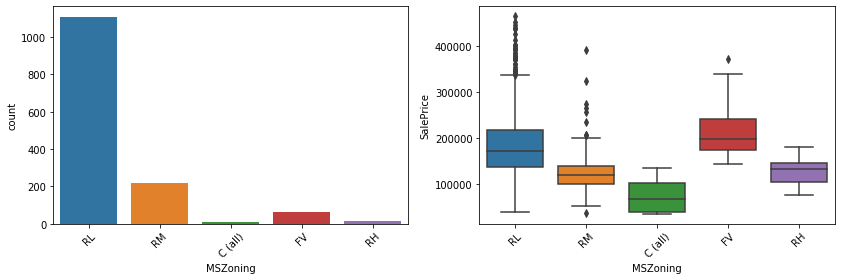

In [128]:
# Visualizing data
plt.figure(figsize= (14,4))
plt.subplot(121)
plt.xticks(rotation= 45)
sns.countplot(data.MSZoning)
plt.subplot(122)
plt.xticks(rotation= 45)
sns.boxplot(data.MSZoning, data.SalePrice)

In [129]:
# The variable is heavily dominated by the value 'RL'
# The median price for all the categories does not differ much
# Hence we can drop this variable from our analysis
data.drop('MSZoning', axis= 1, inplace= True)

In [130]:
# LotShape: General Shape of Property
# Clearly Values 'IR3' and 'IR2' can be dropped
# After this the variable 'LotShape' will become binary 
LotShape= data.LotShape.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
LotShape.reset_index(inplace= True)
LotShape.rename(columns= {'index': 'LotShape'}, inplace= True)
LotShape['percentage']= LotShape['normal_value'].apply(lambda x: 100*round(x, 2)) 
LotShape

,LotShape,normal_value,percentage
0,Reg,0.637845,64.0
1,IR1,0.329554,33.0
2,IR2,0.026931,3.0
3,IR3,0.005670,1.0


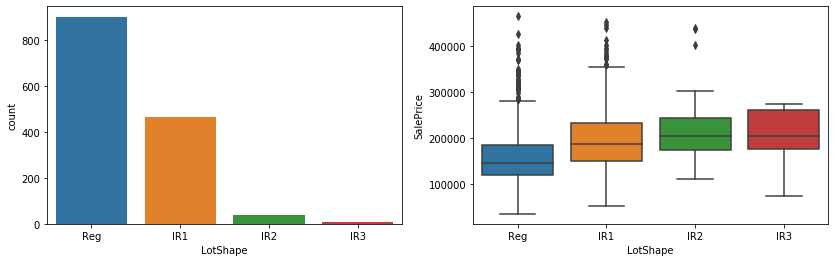

In [131]:
# Visualizing data for variable 'LotShape'
plt.figure(figsize= (14,4))
plt.subplot(121)
sns.countplot(data.LotShape)
plt.subplot(122)
sns.boxplot(data.LotShape, data.SalePrice)

In [132]:
# Since the categories do not have much of an effect on the price, i.e. their median values
# are almost the same we can drop this variable
data.drop('LotShape',axis= 1, inplace= True)

In [133]:
# LotConfig: Lot Configuration
# Clearly Values 'FR3' can be dropped
LotConfig= data.LotConfig.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
LotConfig.reset_index(inplace= True)
LotConfig.rename(columns= {'index': 'LotConfig'}, inplace= True)
LotConfig['percentage']= LotConfig['normal_value'].apply(lambda x: 100*round(x, 2)) 
LotConfig

,LotConfig,normal_value,percentage
0,Inside,0.722183,72.0
1,Corner,0.180014,18.0
2,CulDSac,0.061658,6.0
3,FR2,0.033310,3.0
4,FR3,0.002835,0.0


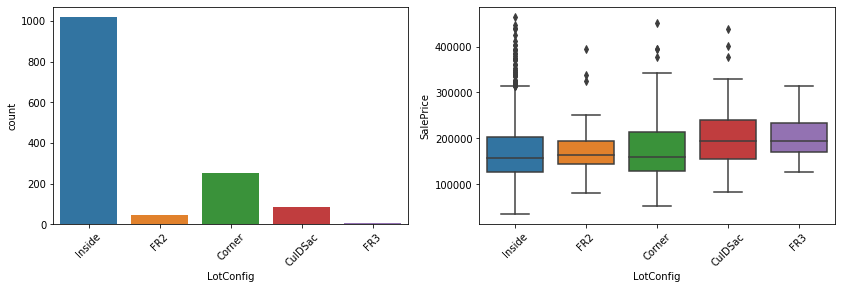

In [134]:
# Visualizing data for variable 'LotConfig'
plt.figure(figsize= (14,4))
plt.subplot(121)
plt.xticks(rotation= 45)
sns.countplot(data.LotConfig)
plt.subplot(122)
plt.xticks(rotation= 45)
sns.boxplot(data.LotConfig, data.SalePrice)

In [135]:
# Since the categories do not have much of an effect on the price, i.e. their median values
# are almost the same we can drop this variable
data.drop('LotConfig', axis= 1, inplace= True)

In [136]:
# Neighborhood: Physical Locations within Ames city Limits
# We will drop all values which are Less than 2 %
Neighborhood= data.Neighborhood.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
Neighborhood.reset_index(inplace= True)
Neighborhood.rename(columns= {'index': 'Neighborhood'}, inplace= True)
Neighborhood['percentage']= Neighborhood['normal_value'].apply(lambda x: 100*round(x, 2)) 
Neighborhood

,Neighborhood,normal_value,percentage
0,NAmes,0.155918,16.0
1,CollgCr,0.105599,11.0
2,OldTown,0.078668,8.0
3,Edwards,0.069454,7.0
4,Somerst,0.058115,6.0
5,Gilbert,0.055989,6.0
6,Sawyer,0.052445,5.0
7,NWAmes,0.051028,5.0
8,NridgHt,0.046775,5.0
9,BrkSide,0.041106,4.0


In [137]:
# Determining the index of values which are less than 2% in the above DataFrame
Neighbor_drop= Neighborhood.loc[Neighborhood.percentage < 3]
Neighbor_Names_drop= Neighbor_drop.Neighborhood
Neighbor_drop_index= []
for i in data.index:
    for j in Neighbor_Names_drop:
        if (data.loc[i,'Neighborhood'] == j):
                Neighbor_drop_index.append(i)
    


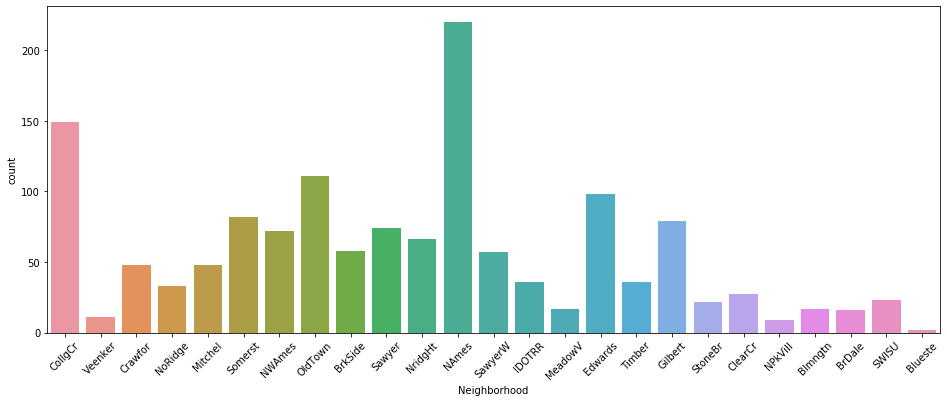

In [138]:
# Visualizing the data
plt.figure(figsize=(16,6))
plt.xticks(rotation=45 )
sns.countplot(data.Neighborhood)

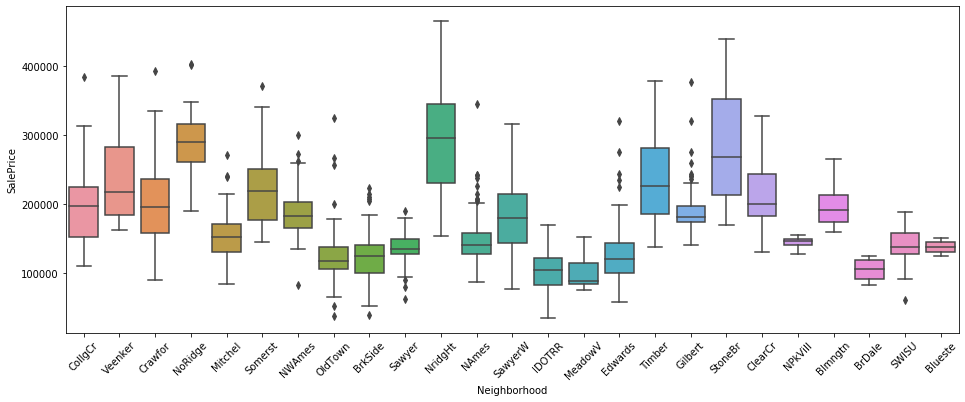

In [139]:
# Visualizing the data before dropping values
plt.figure(figsize=(16,6))
plt.xticks(rotation=45 )
sns.boxplot(data.Neighborhood, data.SalePrice)

In [140]:
# Number of datapoints that will be lost after dropping the values
len(Neighbor_drop_index)

177

In [141]:
#Creating a list of index values which will not be dropped
keep_index= [x for x in data.index if not(x in Neighbor_drop_index) ]

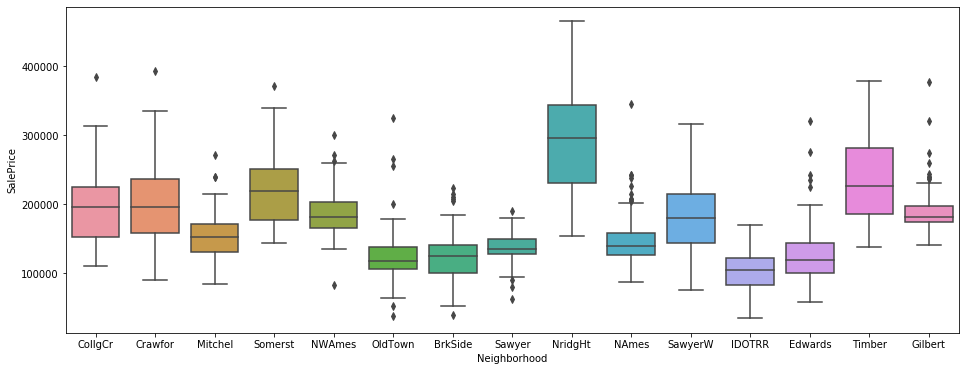

In [142]:
# Visualizing the data after drop
plt.figure(figsize=(16,6))
sns.boxplot(data.loc[keep_index].Neighborhood, data.SalePrice)

In [143]:
# Dropping the values mentioned above
data.drop(Neighbor_drop_index, axis= 0, inplace= True)

In [144]:
# Number of datapoints in our Master DataFrame
len(data.index)

1234

In [145]:
# BldgType: Type of Dwelling
BldgType= data.BldgType.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
BldgType.reset_index(inplace= True)
BldgType.rename(columns= {'index': 'BldgType'}, inplace= True)
BldgType['percentage']= BldgType['normal_value'].apply(lambda x: 100*round(x, 2)) 
BldgType

,BldgType,normal_value,percentage
0,1Fam,0.870340,87.0
1,TwnhsE,0.049433,5.0
2,Duplex,0.042139,4.0
3,2fmCon,0.021880,2.0
4,Twnhs,0.016207,2.0


In [146]:
# Since this variable is heavily dominated by one value, we may drop it from our analysis 
data.drop('BldgType', axis= 1, inplace= True)

In [147]:
# HouseStyle: Style of Dwelling
# Clearly Values 'SFoyer', '1.5Unf', '2.5Unf', '2.5Fin' can be dropped
HouseStyle= data.HouseStyle.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
HouseStyle.reset_index(inplace= True)
HouseStyle.rename(columns= {'index': 'HouseStyle'}, inplace= True)
HouseStyle['percentage']= HouseStyle['normal_value'].apply(lambda x: 100*round(x, 2)) 
HouseStyle

,HouseStyle,normal_value,percentage
0,1Story,0.517018,52.0
1,2Story,0.280389,28.0
2,1.5Fin,0.107780,11.0
3,SLvl,0.047812,5.0
4,SFoyer,0.025122,3.0
5,1.5Unf,0.011345,1.0
6,2.5Unf,0.008914,1.0
7,2.5Fin,0.001621,0.0


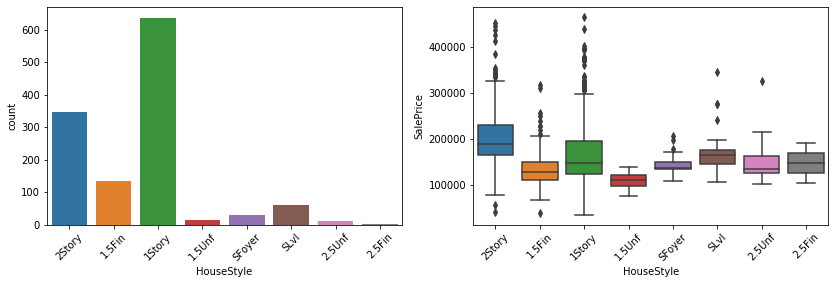

In [149]:
# Visualizing the data before dropping values
plt.figure(figsize= (14,4))
plt.subplot(121)
plt.xticks(rotation= 45)
sns.countplot(data.HouseStyle)
plt.subplot(122)
plt.xticks(rotation= 45)
sns.boxplot(data.HouseStyle, data.SalePrice)

In [152]:
# Since the median value of the categories '2Story', '1Story', '1.5Fin	', 'SLvl' are almost the same
# we can drop this variable
data.drop('HouseStyle', axis= 1, inplace= True)

In [153]:
# Datapoints in our MasterFrame
len(data.index)

1234

In [154]:
# Overall Qual: Rates the overall material and finish of the house
# Clearly values 9, 3, 10, 2 and 1 can be dropped
OverallQual= data.OverallQual.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
OverallQual.reset_index(inplace= True)
OverallQual.rename(columns= {'index': 'OverallQual'}, inplace= True)
OverallQual['percentage']= OverallQual['normal_value'].apply(lambda x: 100*round(x, 2)) 
OverallQual

,OverallQual,normal_value,percentage
0,5,0.298217,30.0
1,6,0.264182,26.0
2,7,0.219611,22.0
3,8,0.088331,9.0
4,4,0.081037,8.0
5,9,0.024311,2.0
6,3,0.015397,2.0
7,10,0.005673,1.0
8,2,0.001621,0.0
9,1,0.001621,0.0


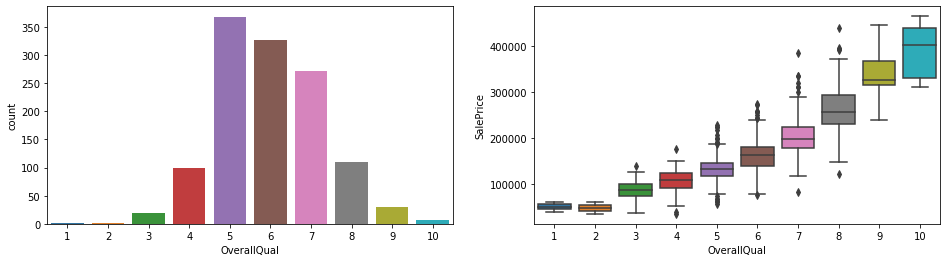

In [155]:
# Visualizing the data before dropping values
# There is clearly as strong relation with the price
plt.figure(figsize= (16,4))
plt.subplot(121)
sns.countplot(data.OverallQual)
plt.subplot(122)
sns.boxplot(data.OverallQual, data.SalePrice)

In [156]:
# Dropping values and mapping the variable 
data.drop(data.loc[(data.OverallQual==9)|(data.OverallQual==3)|(data.OverallQual==2)|(data.OverallQual==1)|(data.OverallQual==10)].index, axis= 0, inplace= True)
data['OverallQual']= data.OverallQual.map({5: 'Average', 6:'Above_Average', 7: 'Good', 8:'Very_Good', 4: 'Below_Average'})

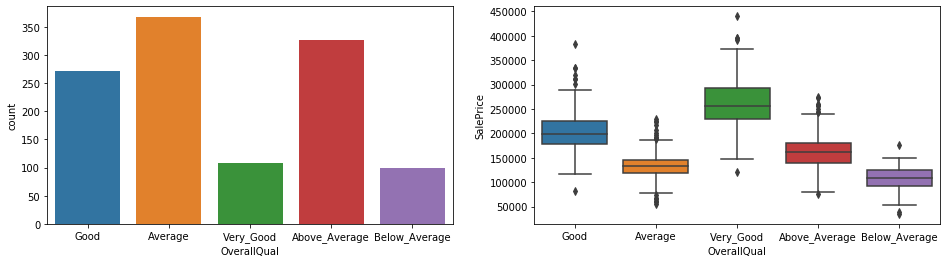

In [157]:
# Visualizing data after drop
plt.figure(figsize= (16,4))
plt.subplot(121)
sns.countplot(data.OverallQual)
plt.subplot(122)
sns.boxplot(data.OverallQual, data.SalePrice)

In [158]:
# Removing outliers
data.drop(data.loc[((data.OverallQual == 'Very_Good') & (data.SalePrice > 360000))|((data.OverallQual == 'Below_Average') & (data.SalePrice > 150000))|((data.OverallQual == 'Good') & (data.SalePrice < 110000))|((data.OverallQual == 'Good') & (data.SalePrice > 300000))|((data.OverallQual == 'Average') & (data.SalePrice < 80000))|((data.OverallQual== 'Average') & (data.SalePrice > 180000))].index, axis= 0, inplace= True)

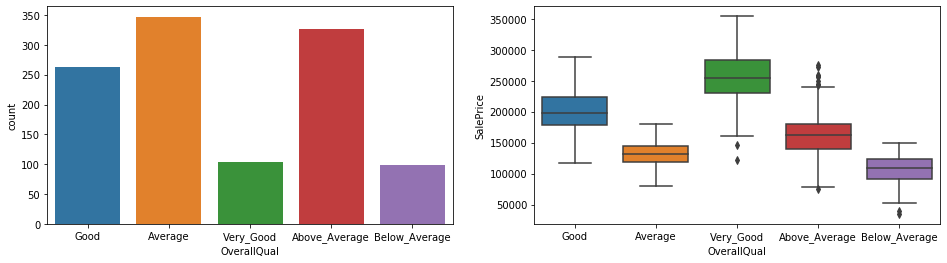

In [159]:
# Visualizing data after drop
plt.figure(figsize= (16,4))
plt.subplot(121)
sns.countplot(data.OverallQual)
plt.subplot(122)
sns.boxplot(data.OverallQual, data.SalePrice)

In [160]:
# Removing Outliers
data.drop(data.loc[((data.OverallQual=='Above_Average') & (data.SalePrice > 250000 ))|((data.OverallQual=='Very_Good') & (data.SalePrice < 155000 ))|((data.OverallQual=='Below_Average') & (data.SalePrice <50000))].index, axis= 0,inplace= True)

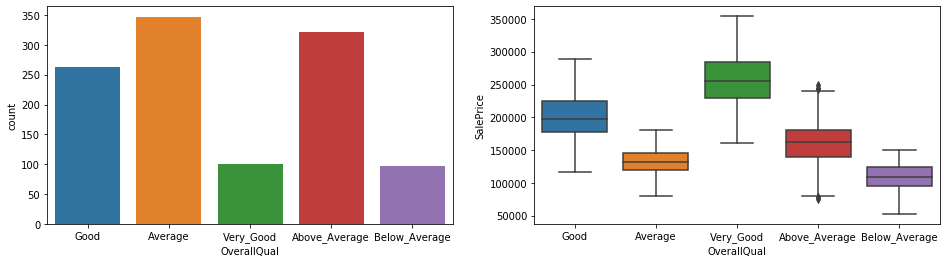

In [161]:
# Visualizing data after drop
plt.figure(figsize= (16,4))
plt.subplot(121)
sns.countplot(data.OverallQual)
plt.subplot(122)
sns.boxplot(data.OverallQual, data.SalePrice)

In [162]:
# Datapoints in our MasterFrame
len(data.index)

1129

In [163]:
# OverallCond : Rates the Overall Condition of the house
# Clearly Values '9', '2', '3'
OverallCond= data.OverallCond.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
OverallCond.reset_index(inplace= True)
OverallCond.rename(columns= {'index': 'OverallCond'}, inplace= True)
OverallCond['percentage']= OverallCond['normal_value'].apply(lambda x: 100*round(x, 2)) 
OverallCond

,OverallCond,normal_value,percentage
0,5,0.548273,55.0
1,6,0.185120,19.0
2,7,0.155004,16.0
3,8,0.051373,5.0
4,4,0.034544,3.0
5,9,0.014172,1.0
6,3,0.010629,1.0
7,2,0.000886,0.0


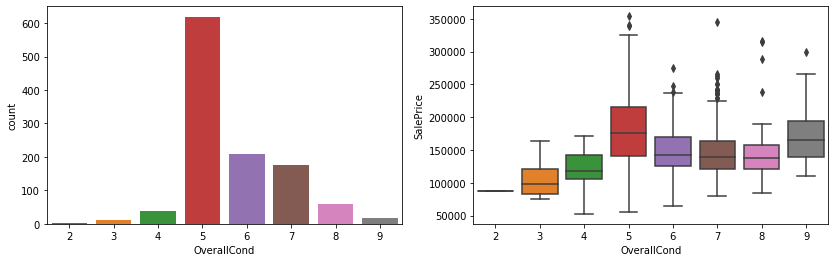

In [164]:
# Visualizing the data before dropping values
plt.figure(figsize= (14,4))
plt.subplot(121)
sns.countplot(data.OverallCond)
plt.subplot(122)
sns.boxplot(data.OverallCond, data.SalePrice)

In [165]:
# Since the categories 5,6,7 and 8 have a similar median price, they will not have much of an
# influence on the price variable
# Hence we can drop this variable entirely
data.drop('OverallCond', axis= 1, inplace= True)

In [166]:
# Datapoints in our MasterFrame
len(data.index)

1129

In [167]:
# Creating bins for bin variables using 150 as maximum age and a bin size of 10
bins= []
max_age= 150
num= 0
while num < max_age:
    bins.append((num, (num + 10)))
    num = num + 10

# Calculating the Age of the Building from the 'YearBuilt' variable
data['Building_Age']= data['YearBuilt'].max() - data['YearBuilt']


In [168]:
# Visualising the Building_Age variable in bins of 10 year intervals 
data.Building_Age.value_counts(bins= 10).sort_index(ascending= True)

(-0.135, 13.4]    346
(13.4, 26.8]       82
(26.8, 40.2]      155
(40.2, 53.6]      223
(53.6, 67.0]      110
(67.0, 80.4]       72
(80.4, 93.8]       90
(93.8, 107.2]      32
(107.2, 120.6]     12
(120.6, 134.0]      7
Name: Building_Age, dtype: int64

In [169]:
# Dropping data values which are above 107
data.drop(data.loc[data.Building_Age > 107].index, axis= 0 , inplace= True)

In [170]:
# Binning the calculated age in the respective bins
bins_YearBuilt=[]
for i in data.index:
    for j in bins:
        if ((data.loc[i, 'Building_Age'] >= j[0]) & (data.loc[i, 'Building_Age'] < j[1])):
            bins_YearBuilt.append(j)

data['Building_Age_bin']= bins_YearBuilt

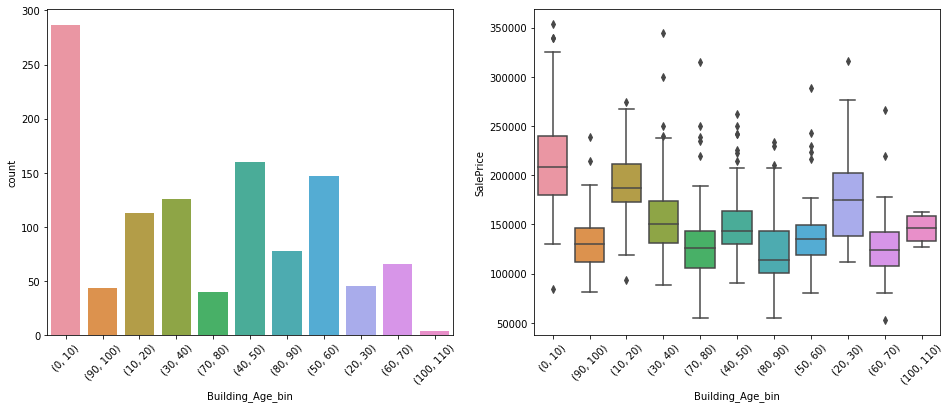

In [171]:
# Visualizing the data
plt.figure(figsize= (16,6))
plt.subplot(121)
plt.xticks(rotation= 45)
sns.countplot(data.Building_Age_bin)
plt.subplot(122)
plt.xticks(rotation= 45)
sns.boxplot(data.Building_Age_bin, data.SalePrice)

In [172]:
# Dropping the 'YearBuilt' and 'Building_Age' variables as they are now excess
# Also dropping bin values (100,110)
data.drop(['YearBuilt', 'Building_Age'], axis= 1, inplace= True)
data.drop(data.loc[data.Building_Age_bin== (100,110)].index, axis= 0, inplace= True)

In [173]:
# Removing outliers
data.drop(data.loc[((data.Building_Age_bin==(30,40)) & (data.SalePrice > 240000 ))|((data.Building_Age_bin==(40,50)) & (data.SalePrice > 210000 ))|((data.Building_Age_bin==(60,70)) & (data.SalePrice > 190000 ))|((data.Building_Age_bin==(10,20)) & (data.SalePrice < 110000 ))|((data.Building_Age_bin==(0,10)) & (data.SalePrice > 330000 ))|((data.Building_Age_bin==(0,10)) & (data.SalePrice < 120000 ))|((data.Building_Age_bin==(50,60)) & (data.SalePrice > 180000 ))|((data.Building_Age_bin==(80,90)) & (data.SalePrice > 200000 ))].index, axis= 0,inplace= True)

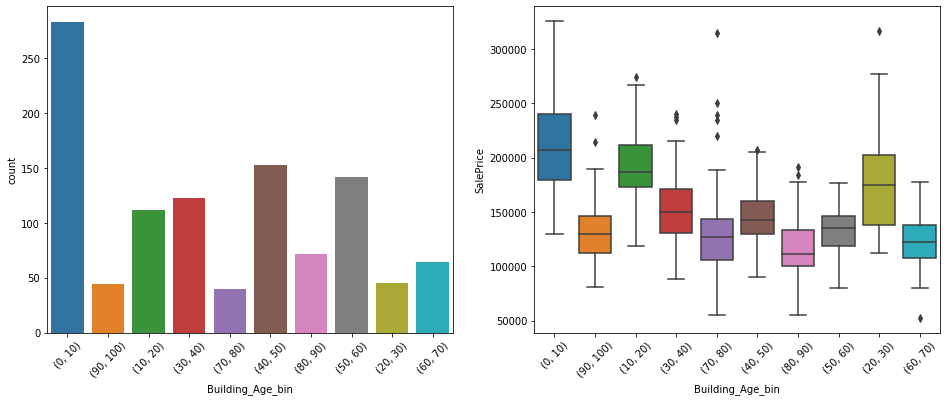

In [174]:
#Visualizing Data after drop
plt.figure(figsize= (16,6))
plt.subplot(121)
plt.xticks(rotation= 45)
sns.countplot(data.Building_Age_bin)
plt.subplot(122)
plt.xticks(rotation= 45)
sns.boxplot(data.Building_Age_bin, data.SalePrice)

In [175]:
# Removing outliers
data.drop(data.loc[((data.Building_Age_bin==(70,80)) & (data.SalePrice > 200000 ))|((data.Building_Age_bin==(90,100)) & (data.SalePrice > 200000 ))|((data.Building_Age_bin==(20,30)) & (data.SalePrice > 290000 ))|((data.Building_Age_bin==(60,70)) & (data.SalePrice < 80000 ))].index, axis= 0,inplace= True)

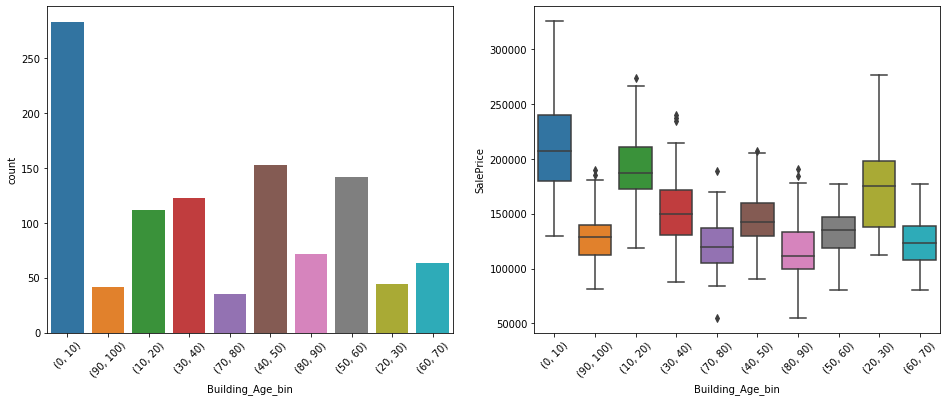

In [176]:
#Visualizing Data after drop
plt.figure(figsize= (16,6))
plt.subplot(121)
plt.xticks(rotation= 45)
sns.countplot(data.Building_Age_bin)
plt.subplot(122)
plt.xticks(rotation= 45)
sns.boxplot(data.Building_Age_bin, data.SalePrice)

In [177]:
# Removing outliers
data.drop(data.loc[((data.Building_Age_bin==(70,80)) & (data.SalePrice < 70000 ))].index, axis=0, inplace= True)

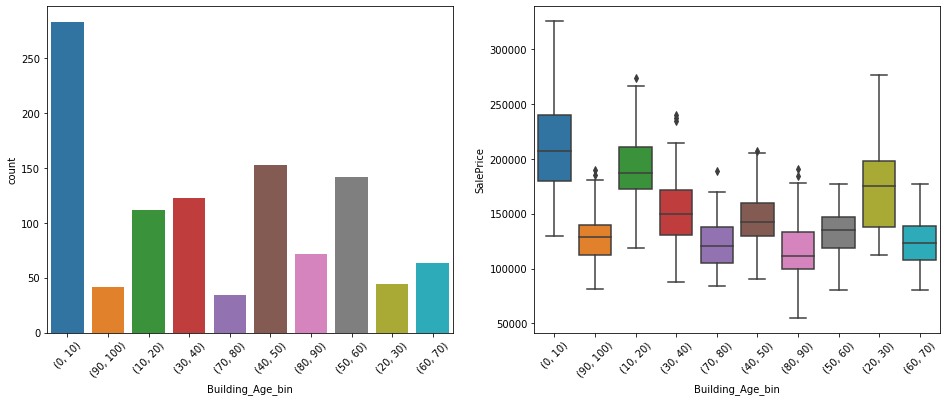

In [178]:
#Visualizing Data after drop
plt.figure(figsize= (16,6))
plt.subplot(121)
plt.xticks(rotation= 45)
sns.countplot(data.Building_Age_bin)
plt.subplot(122)
plt.xticks(rotation= 45)
sns.boxplot(data.Building_Age_bin, data.SalePrice)

In [179]:
# Datapoints in our MasterFrame
len(data.index)

1068

In [180]:
# YearRemodAdd: Remodel Date
# Creating an Age Variable 'RemodAdd_Age'
# Binning the Age in the respective bins
data['RemodAdd_Age']= 2010 - data['YearRemodAdd']

bins_RemodAdd=[]
for i in data.index:
    for j in bins:
        if ((data.loc[i, 'RemodAdd_Age'] >= j[0]) & (data.loc[i, 'RemodAdd_Age'] < j[1])):
            bins_RemodAdd.append(j)

data['Building_RemodAdd_bin']= bins_RemodAdd

In [181]:
# Removing 'RemodAdd_Age' and 'YearRemodAdd' as it is excess
data.drop(['RemodAdd_Age', 'YearRemodAdd'], axis= 1, inplace= True)

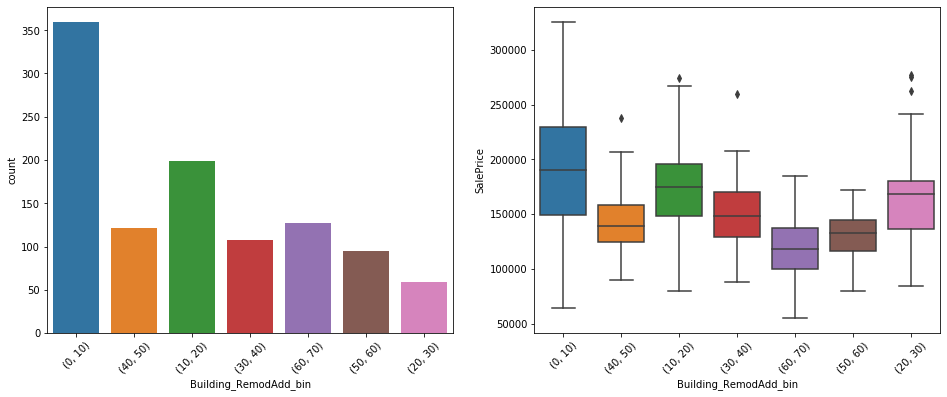

In [182]:
# Visualizing the data before dropping values
plt.figure(figsize= (16,6))
plt.subplot(121)
plt.xticks(rotation= 45)
sns.countplot(data.Building_RemodAdd_bin)
plt.subplot(122)
plt.xticks(rotation= 45)
sns.boxplot(data.Building_RemodAdd_bin, data.SalePrice)

In [183]:
#Since the median price of all the bins are similar, we can drop the variable
data.drop('Building_RemodAdd_bin', axis= 1, inplace= True)

In [184]:
# Datapoints in our MasterFrame
len(data.index)

1068

In [185]:
# RoofStyle: Type of Roof
# This is Clearly a binary variable with values 'Gable' and 'Hip'
# all other values can be dropped
RoofStyle= data.RoofStyle.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
RoofStyle.reset_index(inplace= True)
RoofStyle.rename(columns= {'index': 'RoofStyle'}, inplace= True)
RoofStyle['percentage']= RoofStyle['normal_value'].apply(lambda x: 100*round(x, 2)) 
RoofStyle


,RoofStyle,normal_value,percentage
0,Gable,0.819288,82.0
1,Hip,0.168539,17.0
2,Gambrel,0.005618,1.0
3,Mansard,0.003745,0.0
4,Flat,0.002809,0.0


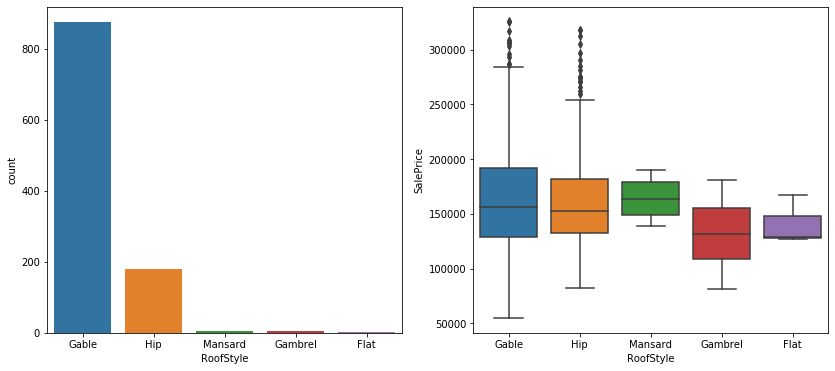

In [186]:
# Visualizing the data before dropping values
plt.figure(figsize= (14,6))
plt.subplot(121)

sns.countplot(data.RoofStyle)
plt.subplot(122)

sns.boxplot(data.RoofStyle, data.SalePrice)

In [187]:
#Since the median price of all the categories are similar, we can drop the variable entirely
data.drop('RoofStyle', axis= 1, inplace= True)

In [188]:
# Datapoints in our MasterFrame
len(data.index)

1068

In [189]:
# Exterior1st: Exterior covering on house
# All values below 1% can be dropped

Exterior1st= data.Exterior1st.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
Exterior1st.reset_index(inplace= True)
Exterior1st.rename(columns= {'index': 'Exterior1st'}, inplace= True)
Exterior1st['percentage']= Exterior1st['normal_value'].apply(lambda x: 100*round(x, 2)) 
Exterior1st

,Exterior1st,normal_value,percentage
0,VinylSd,0.372659,37.0
1,HdBoard,0.169476,17.0
2,MetalSd,0.168539,17.0
3,Wd Sdng,0.132959,13.0
4,Plywood,0.066479,7.0
5,BrkFace,0.025281,3.0
6,CemntBd,0.017790,2.0
7,WdShing,0.017790,2.0
8,AsbShng,0.014045,1.0
9,Stucco,0.013109,1.0


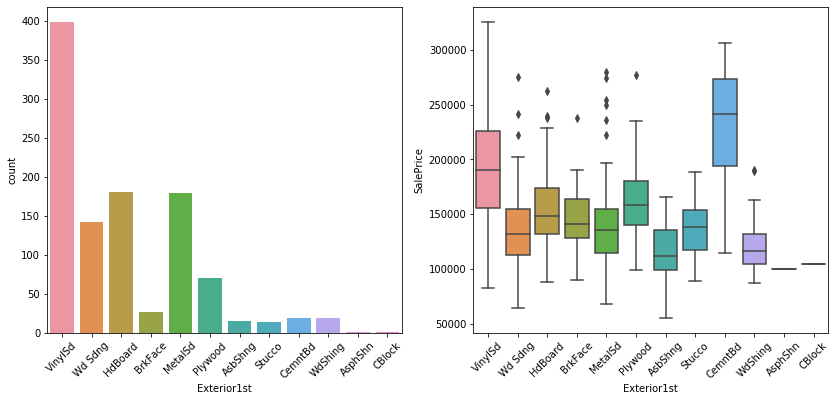

In [190]:
# Visualizing the data before dropping
plt.figure(figsize= (14,6))
plt.subplot(121)
plt.xticks(rotation= 45)
sns.countplot(data.Exterior1st)
plt.subplot(122)
plt.xticks(rotation= 45)
sns.boxplot(data.Exterior1st, data.SalePrice)

In [191]:
# Exterior2nd : Exterior Covering on house
# Drop the values 'Wd Shng', 'ImStucc', 'Stucco', 'BrkFace'
Exterior2nd= data.Exterior2nd.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
Exterior2nd.reset_index(inplace= True)
Exterior2nd.rename(columns= {'index': 'Exterior2nd'}, inplace= True)
Exterior2nd['percentage']= Exterior2nd['normal_value'].apply(lambda x: 100*round(x, 2)) 
Exterior2nd

,Exterior2nd,normal_value,percentage
0,VinylSd,0.366105,37.0
1,MetalSd,0.162921,16.0
2,HdBoard,0.151685,15.0
3,Wd Sdng,0.130150,13.0
4,Plywood,0.097378,10.0
5,Wd Shng,0.026217,3.0
6,CmentBd,0.016854,2.0
7,AsbShng,0.014045,1.0
8,BrkFace,0.013109,1.0
9,Stucco,0.012172,1.0


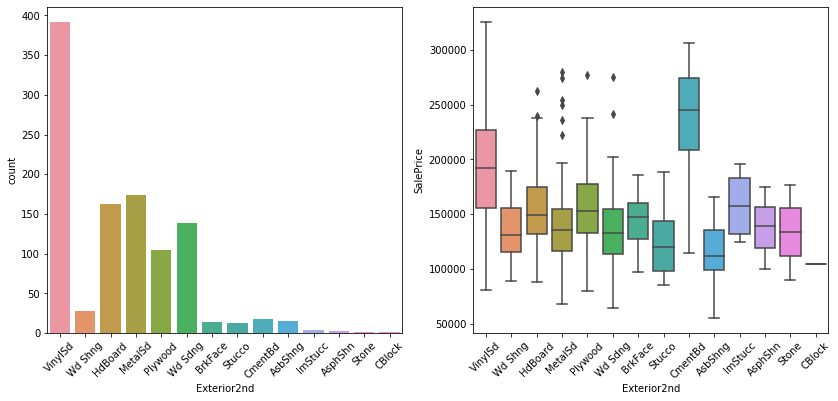

In [192]:
# Visualizing the data for 'Exterior2nd'
plt.figure(figsize= (14,6))
plt.subplot(121)
plt.xticks(rotation= 45)
sns.countplot(data.Exterior2nd)
plt.subplot(122)
plt.xticks(rotation= 45)
sns.boxplot(data.Exterior2nd, data.SalePrice)

In [193]:
# Since in both the variables Exterior2nd Exterior1st the median price of major categories
#are similar, we can drop both the variables
data.drop(['Exterior2nd', 'Exterior1st'], axis= 1, inplace= True)

In [194]:
# MasVnrType: Masonry Veneer type
# Dropping the values 'BrkCmn'
MasVnrType= data.MasVnrType.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
MasVnrType.reset_index(inplace= True)
MasVnrType.rename(columns= {'index': 'MasVnrType'}, inplace= True)
MasVnrType['percentage']= MasVnrType['normal_value'].apply(lambda x: 100*round(x, 2)) 
MasVnrType

,MasVnrType,normal_value,percentage
0,None,0.610487,61.0
1,BrkFace,0.294944,29.0
2,Stone,0.082397,8.0
3,BrkCmn,0.012172,1.0


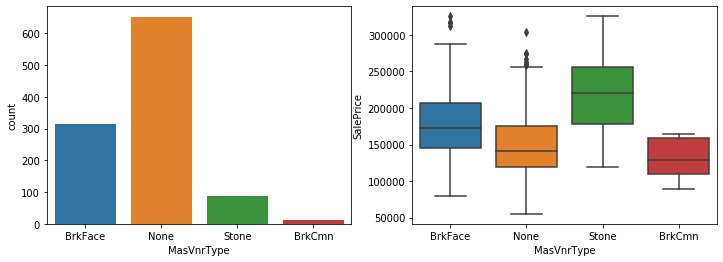

In [195]:
# Visualizing the data
plt.figure(figsize= (12,4))
plt.subplot(121)

sns.countplot(data.MasVnrType)
plt.subplot(122)

sns.boxplot(data.MasVnrType, data.SalePrice)

In [196]:
# Since the median price of major categories are similar, we can drop the variable
data.drop('MasVnrType', axis= 1, inplace= True)

In [197]:
# ExterQual: Evaluates the quality of the material on the exterior
# This is Clearly a binary variable with values 'TA' and 'Gd'
ExterQual= data.ExterQual.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
ExterQual.reset_index(inplace= True)
ExterQual.rename(columns= {'index': 'ExterQual'}, inplace= True)
ExterQual['percentage']= ExterQual['normal_value'].apply(lambda x: 100*round(x, 2)) 
ExterQual

,ExterQual,normal_value,percentage
0,TA,0.673221,67.0
1,Gd,0.315543,32.0
2,Ex,0.005618,1.0
3,Fa,0.005618,1.0


In [198]:
# Dropping values and mapping
data.drop(data.loc[(data.ExterQual=='Ex')|(data.ExterQual=='Fa')].index, axis= 0, inplace= True)
data['ExterQual']= data['ExterQual'].map({'TA':1, 'Gd': 0})

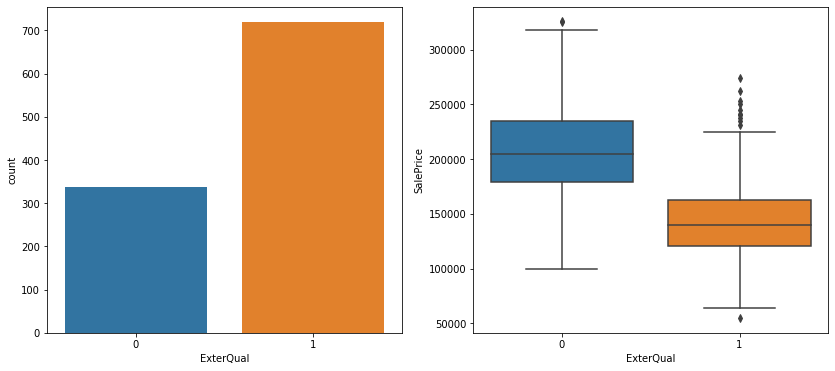

In [199]:
# Visualizing the data
plt.figure(figsize= (14,6))
plt.subplot(121)
sns.countplot(data.ExterQual)
plt.subplot(122)
sns.boxplot(data.ExterQual, data.SalePrice)

In [200]:
# Foundation: Type of foundation
# Dropping the value 'Wood', 'Stone', 'Slab'
Foundation= data.Foundation.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
Foundation.reset_index(inplace= True)
Foundation.rename(columns= {'index': 'Foundation'}, inplace= True)
Foundation['percentage']= Foundation['normal_value'].apply(lambda x: 100*round(x, 2)) 
Foundation

,Foundation,normal_value,percentage
0,CBlock,0.463068,46.0
1,PConc,0.425189,43.0
2,BrkTil,0.089962,9.0
3,Slab,0.017045,2.0
4,Wood,0.002841,0.0
5,Stone,0.001894,0.0


In [201]:
# Dropping and mapping values
data.drop(data.loc[(data.Foundation=='Wood')|(data.Foundation=='Stone')|(data.Foundation=='Slab')].index, axis= 0, inplace= True)
data['Foundation']= data['Foundation'].map({'CBlock': 'Cinder_Block', 'PConc': 'Poured_Concrete', 'BrkTil': 'Brick_and_Tile'})

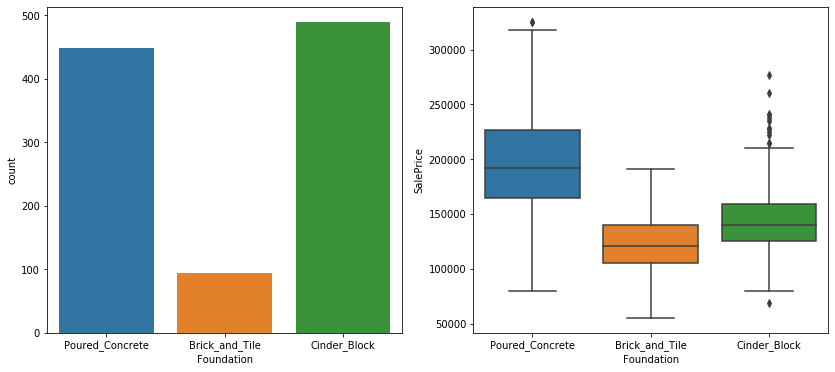

In [202]:
# Visualizing the data
plt.figure(figsize= (14,6))
plt.subplot(121)
sns.countplot(data.Foundation)
plt.subplot(122)
sns.boxplot(data.Foundation, data.SalePrice)

In [203]:
# Dropping outliers
data.drop(data.loc[((data.Foundation=='Cinder_Block') & (data.SalePrice > 210000 ))].index, axis= 0,inplace= True)

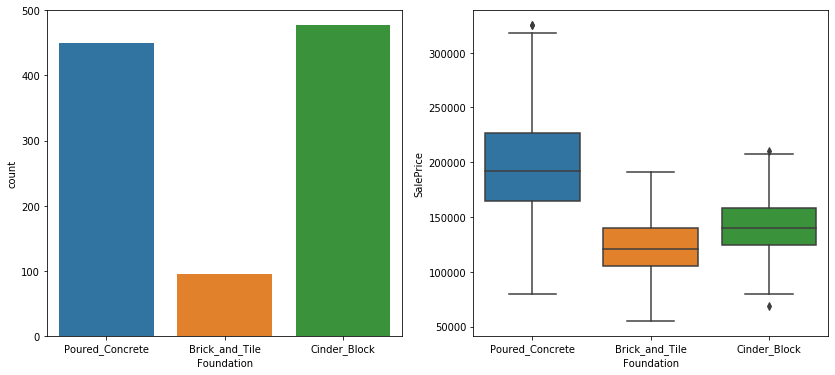

In [204]:
# Visualizing the data
plt.figure(figsize= (14,6))
plt.subplot(121)
sns.countplot(data.Foundation)
plt.subplot(122)
sns.boxplot(data.Foundation, data.SalePrice)

In [205]:
# BsmtQual: Evaluates the height of the basement
# Clearly the values 'Ex' and 'Fa' can be dropped 
BsmtQual= data.BsmtQual.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
BsmtQual.reset_index(inplace= True)
BsmtQual.rename(columns= {'index': 'BsmtQual'}, inplace= True)
BsmtQual['percentage']= BsmtQual['normal_value'].apply(lambda x: 100*round(x, 2)) 
BsmtQual

,BsmtQual,normal_value,percentage
0,TA,0.496572,50.0
1,Gd,0.439765,44.0
2,Ex,0.041136,4.0
3,Fa,0.022527,2.0


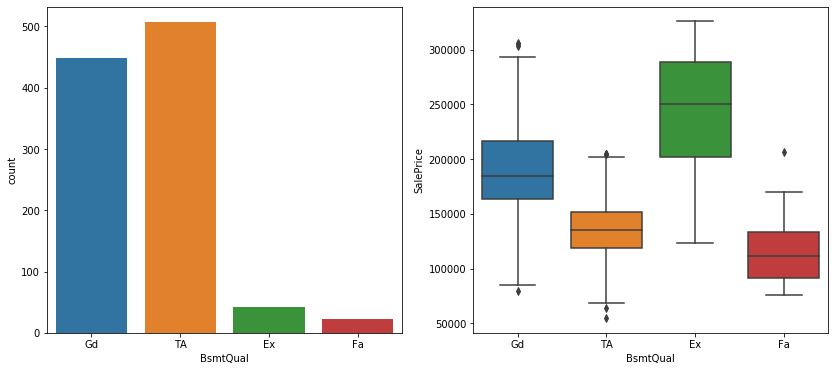

In [206]:
# Visualizing data
plt.figure(figsize= (14,6))
plt.subplot(121)
sns.countplot(data.BsmtQual)
plt.subplot(122)
sns.boxplot(data.BsmtQual, data.SalePrice)

In [207]:
# Dropping and mapping variables
data.drop(data.loc[(data.BsmtQual=='Ex')|(data.BsmtQual=='Fa')].index, axis= 0 , inplace= True)
data['BsmtQual']= data['BsmtQual'].map({'TA': 0, 'Gd': 1})

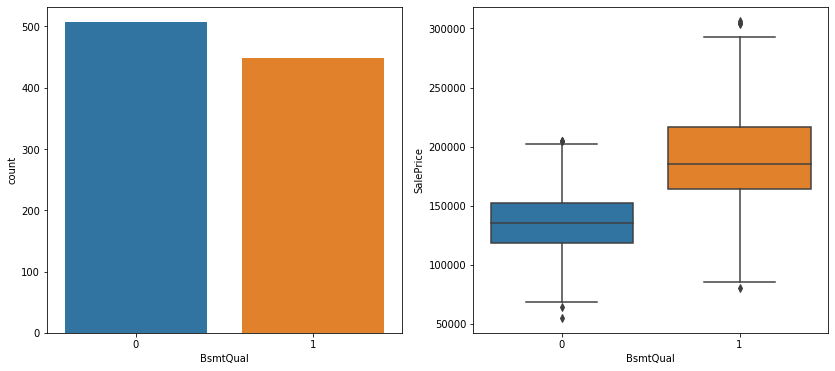

In [208]:
# Visualizing data
plt.figure(figsize= (14,6))
plt.subplot(121)
sns.countplot(data.BsmtQual)
plt.subplot(122)
sns.boxplot(data.BsmtQual, data.SalePrice)

In [209]:
# BsmtExposure: Refers to walkout or Garden level walls
BsmtExposure= data.BsmtExposure.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
BsmtExposure.reset_index(inplace= True)
BsmtExposure.rename(columns= {'index': 'BsmtExposure'}, inplace= True)
BsmtExposure['percentage']= BsmtExposure['normal_value'].apply(lambda x: 100*round(x, 2)) 
BsmtExposure

,BsmtExposure,normal_value,percentage
0,No,0.719665,72.0
1,Av,0.146444,15.0
2,Mn,0.076360,8.0
3,Gd,0.057531,6.0


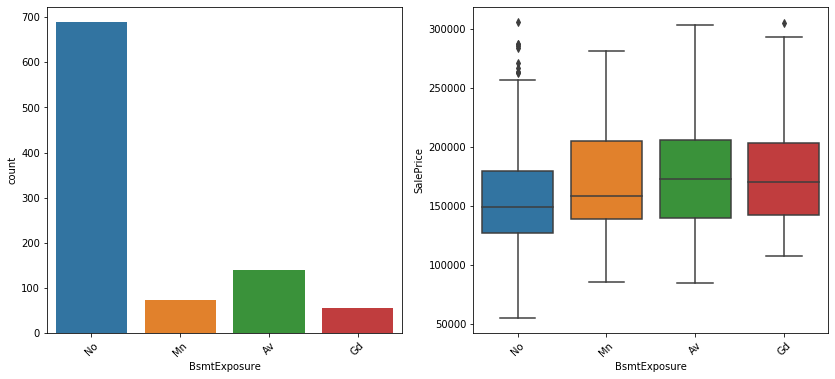

In [210]:
# Visualizing data
plt.figure(figsize= (14,6))
plt.subplot(121)
plt.xticks(rotation= 45)
sns.countplot(data.BsmtExposure)
plt.subplot(122)
plt.xticks(rotation= 45)
sns.boxplot(data.BsmtExposure, data.SalePrice)

In [211]:
# Since all the categories have a similar median price, we may drop the variable
data.drop('BsmtExposure', axis= 1, inplace= True)

In [212]:
# BsmtFinType1: Rating of basement finished area
BsmtFinType1= data.BsmtFinType1.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
BsmtFinType1.reset_index(inplace= True)
BsmtFinType1.rename(columns= {'index': 'BsmtFinType1'}, inplace= True)
BsmtFinType1['percentage']= BsmtFinType1['normal_value'].apply(lambda x: 100*round(x, 2)) 
BsmtFinType1

,BsmtFinType1,normal_value,percentage
0,Unf,0.304393,30.0
1,GLQ,0.257322,26.0
2,ALQ,0.164226,16.0
3,BLQ,0.117155,12.0
4,Rec,0.110879,11.0
5,LwQ,0.046025,5.0


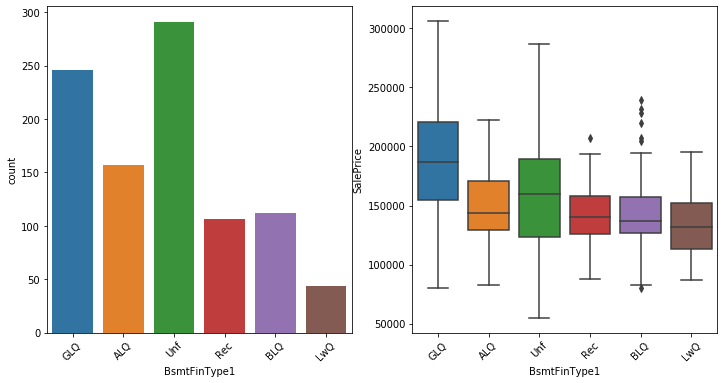

In [213]:
# Visualizing data
plt.figure(figsize= (12,6))
plt.subplot(121)
plt.xticks(rotation= 45)
sns.countplot(data.BsmtFinType1)
plt.subplot(122)
plt.xticks(rotation= 45)
sns.boxplot(data.BsmtFinType1, data.SalePrice)

In [214]:
# Since all the categories have a similar median price, we may drop the variable
data.drop('BsmtFinType1', axis= 1, inplace= True)

In [215]:
# HeatingQC: Heating Quality and Condition
# Drop the value 'Fa'
HeatingQC= data.HeatingQC.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
HeatingQC.reset_index(inplace= True)
HeatingQC.rename(columns= {'index': 'HeatingQC'}, inplace= True)
HeatingQC['percentage']= HeatingQC['normal_value'].apply(lambda x: 100*round(x, 2)) 
HeatingQC

,HeatingQC,normal_value,percentage
0,Ex,0.487448,49.0
1,TA,0.312762,31.0
2,Gd,0.170502,17.0
3,Fa,0.028243,3.0
4,Po,0.001046,0.0


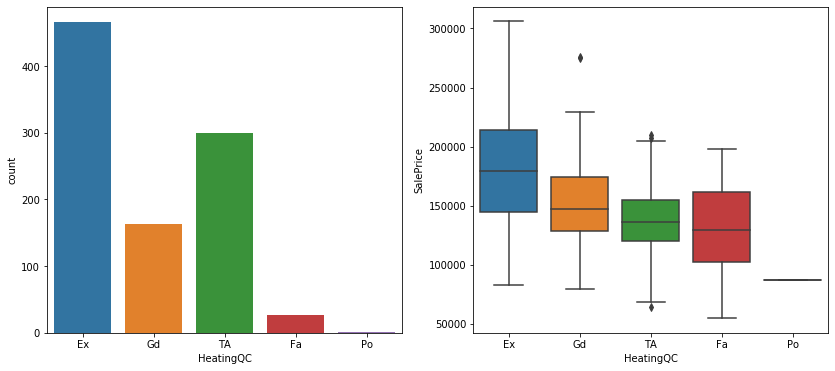

In [216]:
# Visualizing data
plt.figure(figsize= (14,6))
plt.subplot(121)
sns.countplot(data.HeatingQC)
plt.subplot(122)
sns.boxplot(data.HeatingQC, data.SalePrice)

In [217]:
# Dropping and mapping values
data.drop(data.loc[data.HeatingQC== 'Fa'].index, axis= 0, inplace= True)
data['HeatingQC']= data['HeatingQC'].map({'Ex': 'Excellent', 'TA': 'Average_Typical', 'Gd': 'Good'})

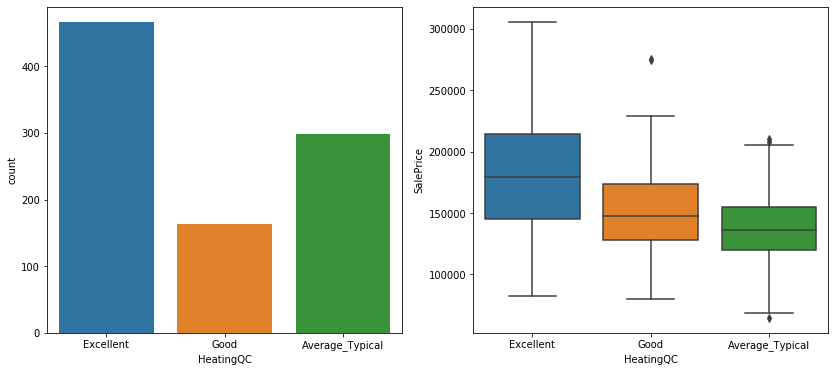

In [218]:
# Visualizing data
plt.figure(figsize= (14,6))
plt.subplot(121)
sns.countplot(data.HeatingQC)
plt.subplot(122)
sns.boxplot(data.HeatingQC, data.SalePrice)

In [219]:
data.drop(data.loc[(data.HeatingQC=='Good')&(data.SalePrice > 250000)].index, axis= 0, inplace= True)

In [220]:
# BsmtFullBath: Basement full bathrooms

BsmtFullBath= data.BsmtFullBath.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
BsmtFullBath.reset_index(inplace= True)
BsmtFullBath.rename(columns= {'index': 'BsmtFullBath'}, inplace= True)
BsmtFullBath['percentage']= BsmtFullBath['normal_value'].apply(lambda x: 100*round(x, 2)) 
BsmtFullBath

,BsmtFullBath,normal_value,percentage
0,0,0.604099,60.0
1,1,0.389428,39.0
2,2,0.005394,1.0
3,3,0.001079,0.0


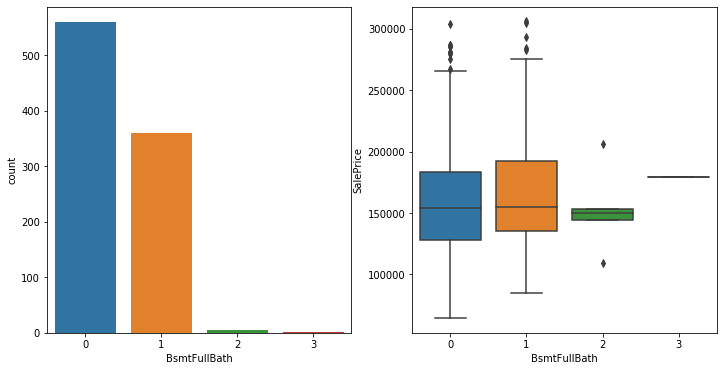

In [221]:
# Visualizing data
plt.figure(figsize= (12,6))
plt.subplot(121)
sns.countplot(data.BsmtFullBath)
plt.subplot(122)
sns.boxplot(data.BsmtFullBath, data.SalePrice)

In [222]:
# Since all the categories have a similar median price, we may drop the variable
data.drop('BsmtFullBath', axis= 1, inplace= True)

In [223]:
# FullBath: Full bathrooms above Grade
# the value '3' can be dropped
FullBath= data.FullBath.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
FullBath.reset_index(inplace= True)
FullBath.rename(columns= {'index': 'FullBath'}, inplace= True)
FullBath['percentage']= FullBath['normal_value'].apply(lambda x: 100*round(x, 2)) 
FullBath

,FullBath,normal_value,percentage
0,1,0.502697,50.0
1,2,0.487594,49.0
2,3,0.005394,1.0
3,0,0.004315,0.0


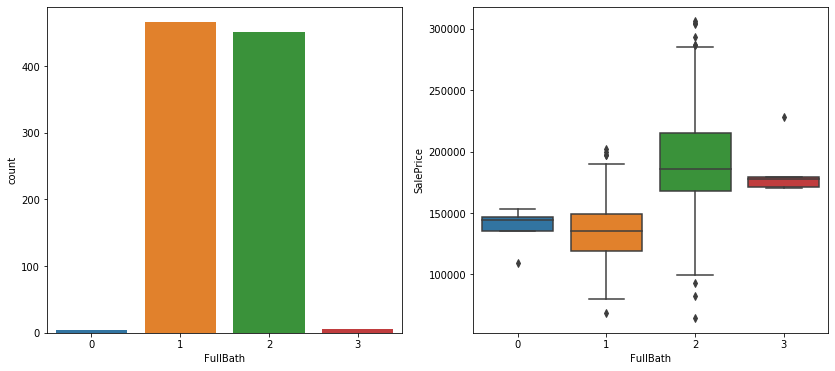

In [224]:
# Visualizing data
plt.figure(figsize= (14,6))
plt.subplot(121)
sns.countplot(data.FullBath)
plt.subplot(122)
sns.boxplot(data.FullBath, data.SalePrice)

In [225]:
data.drop(data.loc[data.FullBath== 3].index, axis= 0, inplace= True)
data['FullBath']= data['FullBath'].map({2: 1, 1:0})

In [226]:
data.drop(data.loc[((data.FullBath==1) & (data.SalePrice < 90000 ))].index, axis= 0,inplace= True)

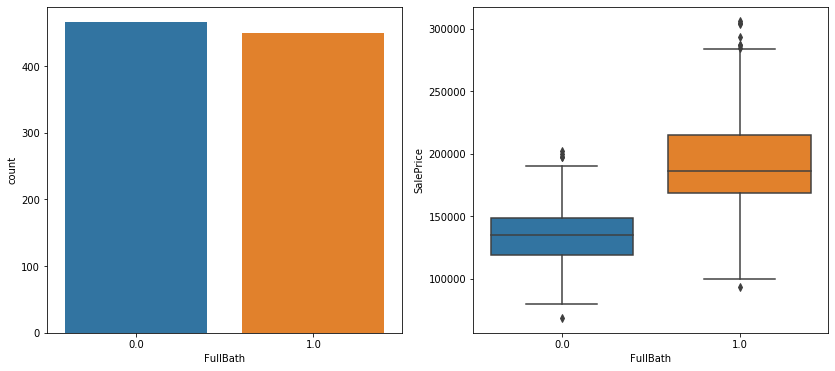

In [227]:
# Visualizing data
plt.figure(figsize= (14,6))
plt.subplot(121)
sns.countplot(data.FullBath)
plt.subplot(122)
sns.boxplot(data.FullBath, data.SalePrice)

In [228]:
# HalfBath: Half baths above grade
# Clearly the value '2' can be dropped 
HalfBath= data.HalfBath.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
HalfBath.reset_index(inplace= True)
HalfBath.rename(columns= {'index': 'HalfBath'}, inplace= True)
HalfBath['percentage']= HalfBath['normal_value'].apply(lambda x: 100*round(x, 2)) 
HalfBath

,HalfBath,normal_value,percentage
0,0,0.647826,65.0
1,1,0.343478,34.0
2,2,0.008696,1.0


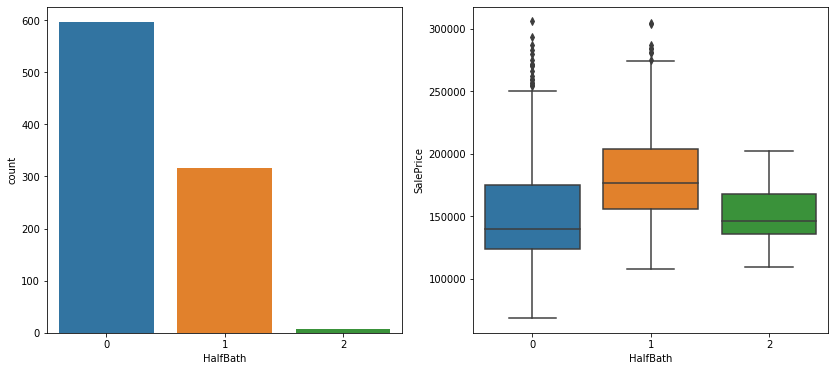

In [229]:
# Visualizing the data
plt.figure(figsize= (14,6))
plt.subplot(121)
sns.countplot(data.HalfBath)
plt.subplot(122)
sns.boxplot(data.HalfBath, data.SalePrice)

In [230]:
# Since all the categories have a similar median price, we may drop the variable
data.drop('HalfBath', axis= 1, inplace= True)

In [231]:
# BedroomAbvGr: Bedrooms above Grade
# Clearly the value '1', '6' and '5' can be dropped 
BedroomAbvGr= data.BedroomAbvGr.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
BedroomAbvGr.reset_index(inplace= True)
BedroomAbvGr.rename(columns= {'index': 'BedroomAbvGr'}, inplace= True)
BedroomAbvGr['percentage']= BedroomAbvGr['normal_value'].apply(lambda x: 100*round(x, 2)) 
BedroomAbvGr

,BedroomAbvGr,normal_value,percentage
0,3,0.640217,64.0
1,2,0.227174,23.0
2,4,0.100000,10.0
3,1,0.019565,2.0
4,5,0.005435,1.0
5,6,0.004348,0.0
6,0,0.003261,0.0


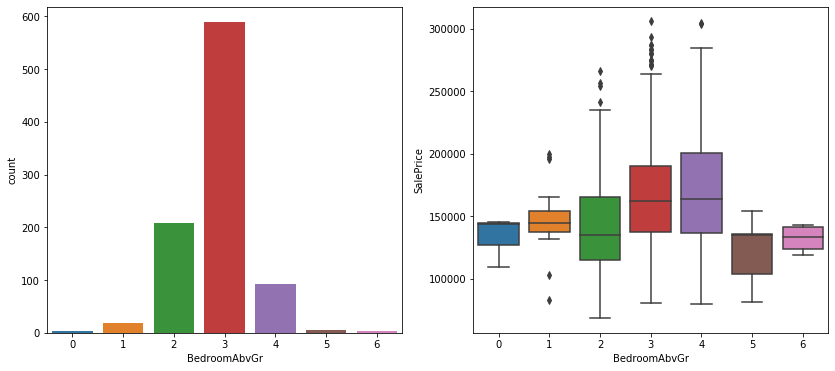

In [232]:
# Visualizing the data
plt.figure(figsize= (14,6))
plt.subplot(121)
sns.countplot(data.BedroomAbvGr)
plt.subplot(122)
sns.boxplot(data.BedroomAbvGr, data.SalePrice)

In [233]:
# Since all the major categories have similar median prices, we may drop the variable
data.drop('BedroomAbvGr', axis= 1, inplace= True)

In [234]:
# KitchenQual: Kitchen Quality
# Clearly the value 'Fa' and 'Ex' can be dropped  and 'KitchenQual' becomes a binary variable
KitchenQual= data.KitchenQual.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
KitchenQual.reset_index(inplace= True)
KitchenQual.rename(columns= {'index': 'KitchenQual'}, inplace= True)
KitchenQual['percentage']= KitchenQual['normal_value'].apply(lambda x: 100*round(x, 2)) 
KitchenQual

,KitchenQual,normal_value,percentage
0,TA,0.548913,55.0
1,Gd,0.418478,42.0
2,Fa,0.017391,2.0
3,Ex,0.015217,2.0


In [235]:
# Dropping and mapping values
data.drop(data.loc[(data.KitchenQual=='Fa')|(data.KitchenQual=='Ex')].index, axis= 0 , inplace= True)
data['KitchenQual']= data['KitchenQual'].map({'TA': 1, 'Gd': 0})

In [236]:
data.drop(data.loc[((data.KitchenQual==1) & (data.SalePrice > 200000 ))].index, axis= 0,inplace= True)

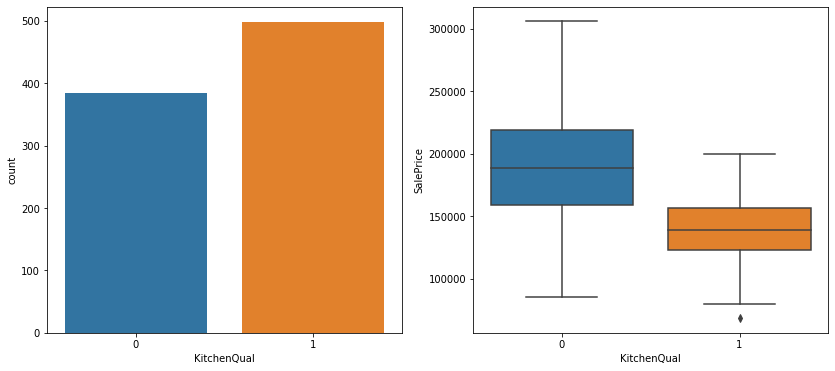

In [237]:
# Visualizing data
plt.figure(figsize= (14,6))
plt.subplot(121)
sns.countplot(data.KitchenQual)
plt.subplot(122)
sns.boxplot(data.KitchenQual, data.SalePrice)

In [238]:
# TotRmsAbvGrd: Total rooms above grade
# Clearly the values '9','10', '3' can be dropped
TotRmsAbvGrd= data.TotRmsAbvGrd.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
TotRmsAbvGrd.reset_index(inplace= True)
TotRmsAbvGrd.rename(columns= {'index': 'TotRmsAbvGrd'}, inplace= True)
TotRmsAbvGrd['percentage']= TotRmsAbvGrd['normal_value'].apply(lambda x: 100*round(x, 2)) 
TotRmsAbvGrd

,TotRmsAbvGrd,normal_value,percentage
0,6,0.321631,32.0
1,7,0.225368,23.0
2,5,0.218573,22.0
3,8,0.116648,12.0
4,4,0.073613,7.0
5,9,0.021518,2.0
6,10,0.011325,1.0
7,3,0.010193,1.0
8,12,0.001133,0.0


In [239]:
data.drop(data.loc[(data.TotRmsAbvGrd== 9)|(data.TotRmsAbvGrd== 10)|(data.TotRmsAbvGrd== 3)|(data.TotRmsAbvGrd== 12)].index, axis= 0, inplace= True)

In [240]:
data.drop(data.loc[((data.TotRmsAbvGrd==4) & (data.SalePrice > 180000 ))|((data.TotRmsAbvGrd==5) & (data.SalePrice > 170000 ))|((data.TotRmsAbvGrd==6) & (data.SalePrice > 230000 ))].index, axis= 0,inplace= True)

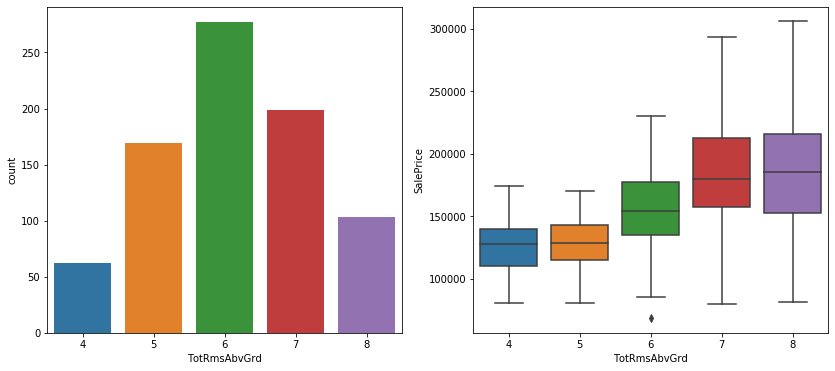

In [241]:
# Visualizing data
plt.figure(figsize= (14,6))
plt.subplot(121)
sns.countplot(data.TotRmsAbvGrd)
plt.subplot(122)
sns.boxplot(data.TotRmsAbvGrd, data.SalePrice)

In [242]:
# Fireplaces: Number of Fireplaces
# Clearly the value  '3' can be dropped 
Fireplaces= data.Fireplaces.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
Fireplaces.reset_index(inplace= True)
Fireplaces.rename(columns= {'index': 'Fireplaces'}, inplace= True)
Fireplaces['percentage']= Fireplaces['normal_value'].apply(lambda x: 100*round(x, 2)) 
Fireplaces

,Fireplaces,normal_value,percentage
0,0,0.555556,56.0
1,1,0.391358,39.0
2,2,0.053086,5.0


In [243]:
data.drop(data.loc[((data.Fireplaces==1) & (data.SalePrice > 280000 ))|(data.Fireplaces==2)].index, axis= 0,inplace= True)

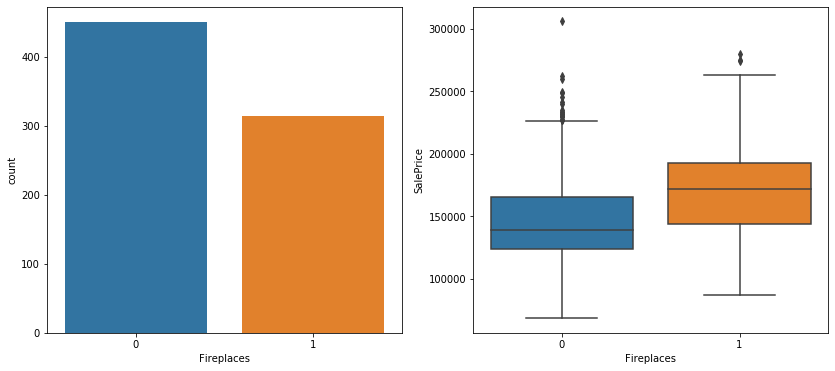

In [244]:
# Visualizing data
plt.figure(figsize= (14,6))
plt.subplot(121)
sns.countplot(data.Fireplaces)
plt.subplot(122)
sns.boxplot(data.Fireplaces, data.SalePrice)

In [245]:
data.drop(data.loc[((data.Fireplaces==0) & (data.SalePrice > 250000 ))].index, axis= 0,inplace= True)

In [246]:
# GarageType: Garage Location
GarageType= data.GarageType.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
GarageType.reset_index(inplace= True)
GarageType.rename(columns= {'index': 'GarageType'}, inplace= True)
GarageType['percentage']= GarageType['normal_value'].apply(lambda x: 100*round(x, 2)) 
GarageType

,GarageType,normal_value,percentage
0,Attchd,0.603154,60.0
1,Detchd,0.335085,34.0
2,BuiltIn,0.045992,5.0
3,Basment,0.010512,1.0
4,CarPort,0.003942,0.0
5,2Types,0.001314,0.0


In [247]:
# Dropping and mapping values
data.drop(data.loc[(data.GarageType=='Basment')|(data.GarageType=='CarPort')|(data.GarageType=='2Types')|(data.GarageType=='BuiltIn')].index, axis= 0, inplace= True)
data['GarageType']= data['GarageType'].map({'Attchd': 1, 'Detchd': 0})

In [248]:
data.GarageType.value_counts()

1    459
0    255
Name: GarageType, dtype: int64

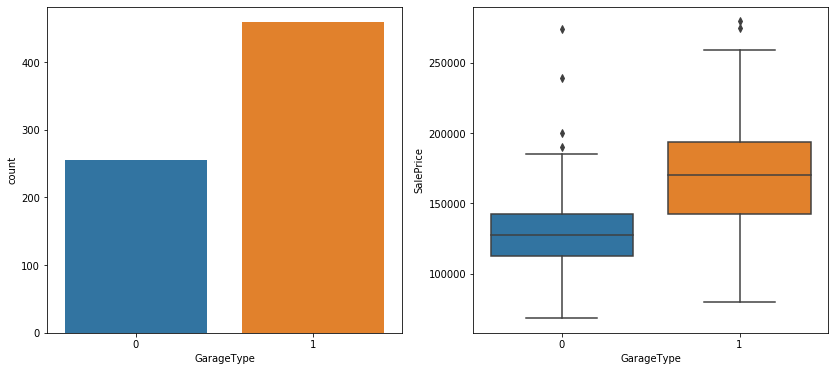

In [249]:
# Visualizing data
plt.figure(figsize= (14,6))
plt.subplot(121)
sns.countplot(data.GarageType)
plt.subplot(122)
sns.boxplot(data.GarageType, data.SalePrice)

In [250]:
data.drop(data.loc[((data.GarageType==0) & (data.SalePrice > 200000 ))].index, axis= 0,inplace= True)

In [251]:
# GarageFinish: Interior finish of the garage
GarageFinish= data.GarageFinish.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
GarageFinish.reset_index(inplace= True)
GarageFinish.rename(columns= {'index': 'GarageFinish'}, inplace= True)
GarageFinish['percentage']= GarageFinish['normal_value'].apply(lambda x: 100*round(x, 2)) 
GarageFinish

,GarageFinish,normal_value,percentage
0,Unf,0.519663,52.0
1,RFn,0.331461,33.0
2,Fin,0.148876,15.0


In [252]:
# Mapping values
data['GarageFinish']= data['GarageFinish'].map({'Unf': 'Unfinished', 'RFn': 'Rough_Finished', 'Fin': 'Finished'})

In [253]:
data.drop(data.loc[((data.GarageFinish=='Unfinished') & (data.SalePrice > 200000 ))|((data.GarageFinish=='Finished') & (data.SalePrice < 110000 ))|((data.GarageFinish=='Finished') & (data.SalePrice > 235000 ))].index, axis= 0,inplace= True)

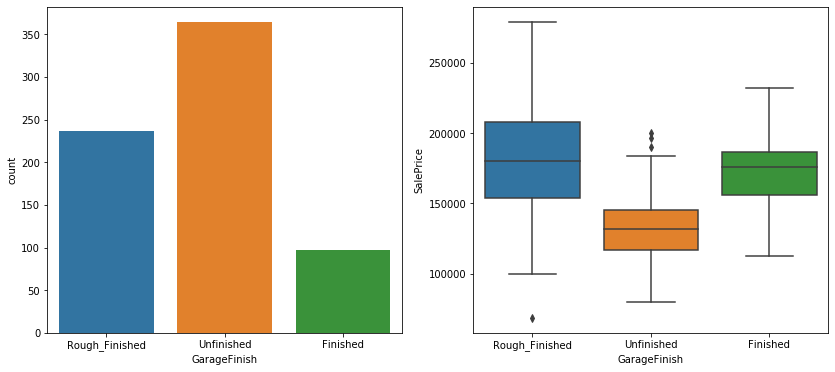

In [254]:
# Visualizing data
plt.figure(figsize= (14,6))
plt.subplot(121)
sns.countplot(data.GarageFinish)
plt.subplot(122)
sns.boxplot(data.GarageFinish, data.SalePrice)


In [255]:
# GarageCars: Size of Garage in car capacity
# Dropping values '3' and '4'
GarageCars= data.GarageCars.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
GarageCars.reset_index(inplace= True)
GarageCars.rename(columns= {'index': 'GarageCars'}, inplace= True)
GarageCars['percentage']= GarageCars['normal_value'].apply(lambda x: 100*round(x, 2)) 
GarageCars

,GarageCars,normal_value,percentage
0,2,0.589670,59.0
1,1,0.325681,33.0
2,0,0.048780,5.0
3,3,0.034433,3.0
4,4,0.001435,0.0


In [256]:
# Dropping and mapping values
data.drop(data.loc[(data.GarageCars== 4)].index, axis= 0, inplace= True)
data['GarageCars']= data['GarageCars'].map({2: 2, 1: 1,0:0,3:3})

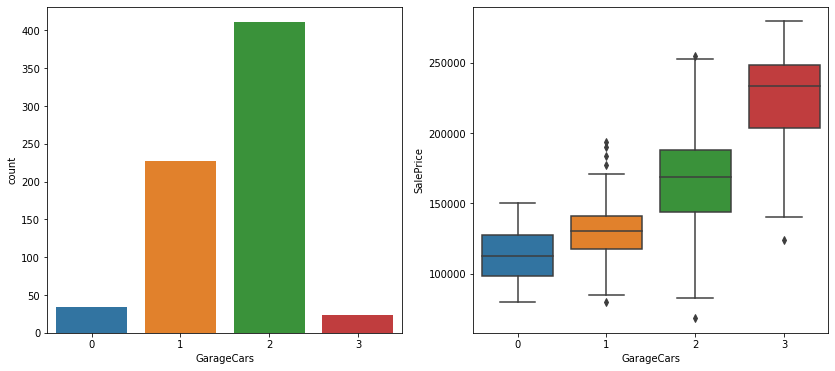

In [257]:
# Visualizing data
plt.figure(figsize= (14,6))
plt.subplot(121)
sns.countplot(data.GarageCars)
plt.subplot(122)
sns.boxplot(data.GarageCars, data.SalePrice)


In [258]:
data.drop(data.loc[(data.GarageCars==1) & (data.SalePrice > 170000)].index, axis= 0, inplace= True)

In [259]:
# Creating a variable Sale_Age
data['Sale_Age']= 2010 - data['YrSold']

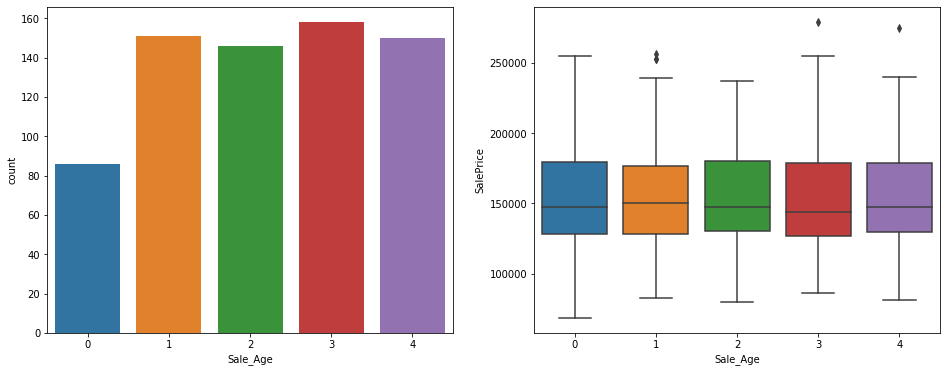

In [260]:
plt.figure(figsize= (16,6))
plt.subplot(121)

sns.countplot(data.Sale_Age)
plt.subplot(122)

sns.boxplot(data.Sale_Age, data.SalePrice)

In [261]:
# Since the median price is the same, dropping the variable
data.drop(['Sale_Age', 'YrSold'], axis= 1, inplace= True)

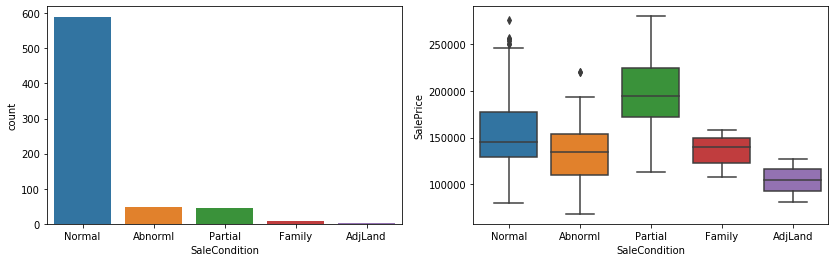

In [262]:
# Visualizing data for Variable SaleCondition
plt.figure(figsize= (14,4))
plt.subplot(121)
sns.countplot(data.SaleCondition)
plt.subplot(122)
sns.boxplot(data.SaleCondition, data.SalePrice)


In [263]:
# Since it is dominated by one variable, we may drop it from our analysis
data.drop('SaleCondition', axis= 1, inplace= True)

In [264]:
# Mapping values for month

data['MoSold']= data['MoSold'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})

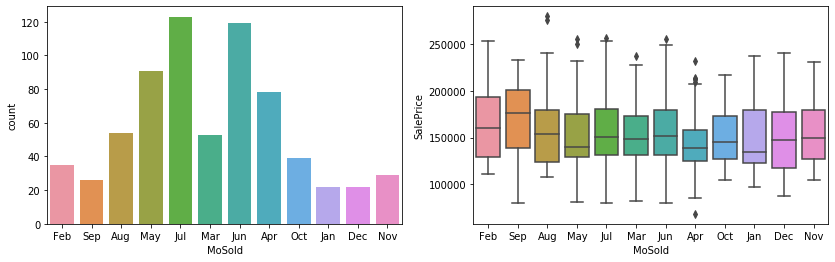

In [265]:
# Visualizing data
plt.figure(figsize= (14,4))
plt.subplot(121)
sns.countplot(data.MoSold)
plt.subplot(122)
sns.boxplot(data.MoSold, data.SalePrice)


In [266]:
# Since the median price is the same, we may drop the variable
data.drop('MoSold', axis= 1, inplace= True)

In [267]:
MSSubClass= data.MSSubClass.value_counts(normalize= True, sort= True).to_frame(name= 'normal_value')
MSSubClass.reset_index(inplace= True)
MSSubClass.rename(columns= {'index': 'MSSubClass'}, inplace= True)
MSSubClass['percentage']= MSSubClass['normal_value'].apply(lambda x: 100*round(x, 2)) 
MSSubClass

,MSSubClass,normal_value,percentage
0,20,0.470333,47.0
1,60,0.182344,18.0
2,50,0.101302,10.0
3,30,0.047757,5.0
4,80,0.036179,4.0
5,160,0.031838,3.0
6,120,0.027496,3.0
7,90,0.026049,3.0
8,85,0.023155,2.0
9,70,0.018813,2.0


In [268]:
# indexes to drop
to_drop= []
drop_list= [80,160,120,90,85,70,190,45,75,40]

for i in data.index:
    if (data.loc[i,'MSSubClass'] in drop_list):
        to_drop.append(i)

    

In [269]:
# dropping data
data.drop(to_drop, axis= 0, inplace= True)

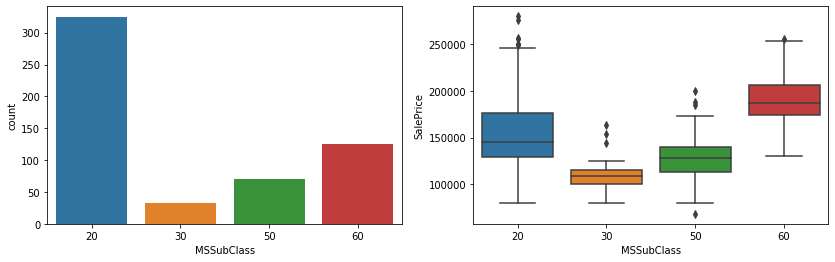

In [270]:
# Visualizing data
plt.figure(figsize= (14,4))
plt.subplot(121)
sns.countplot(data.MSSubClass)
plt.subplot(122)
sns.boxplot(data.MSSubClass, data.SalePrice)


## Creating Dummy Variables

In [271]:
# List of variable for which dummy variables must be created
Dummy_variables= ['Neighborhood', 'OverallQual','Building_Age_bin','Foundation','HeatingQC', 'TotRmsAbvGrd','GarageFinish','KitchenQual','GarageCars','MSSubClass']

In [272]:
# Creating model dataframe
model= data
model

,Id,MSSubClass,Neighborhood,OverallQual,ExterQual,Foundation,BsmtQual,TotalBsmtSF,HeatingQC,FirstFlrSF,...,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,SalePrice,Building_Age_bin
0,1,60,CollgCr,Good,0,Poured_Concrete,1,856,Excellent,856,...,0,8,0,1,2003.0,Rough_Finished,2,548,208500,"(0, 10)"
2,3,60,CollgCr,Good,0,Poured_Concrete,1,920,Excellent,920,...,0,6,1,1,2001.0,Rough_Finished,2,608,223500,"(0, 10)"
10,11,20,Sawyer,Average,1,Cinder_Block,0,1040,Excellent,1040,...,1,5,0,0,1965.0,Unfinished,1,384,129500,"(40, 50)"
12,13,20,Sawyer,Average,1,Cinder_Block,0,912,Average_Typical,912,...,1,4,0,0,1962.0,Unfinished,1,352,144000,"(40, 50)"
13,14,20,CollgCr,Good,0,Poured_Concrete,1,1494,Excellent,1494,...,0,7,1,1,2006.0,Rough_Finished,3,840,279500,"(0, 10)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,1448,60,CollgCr,Very_Good,0,Poured_Concrete,1,1220,Excellent,1220,...,0,8,1,1,1995.0,Rough_Finished,2,556,240000,"(10, 20)"
1454,1455,20,Somerst,Good,0,Poured_Concrete,1,1221,Excellent,1221,...,0,6,0,1,2004.0,Rough_Finished,2,400,185000,"(0, 10)"
1455,1456,60,Gilbert,Above_Average,1,Poured_Concrete,1,953,Excellent,953,...,1,7,1,1,1999.0,Rough_Finished,2,460,175000,"(10, 20)"
1458,1459,20,NAmes,Average,1,Cinder_Block,0,1078,Good,1078,...,0,5,0,1,1950.0,Unfinished,1,240,142125,"(50, 60)"


In [273]:
# Creating the dummy variables
for i in Dummy_variables:
    model= pd.concat([model, pd.get_dummies(model[i], drop_first= True, prefix= i)], axis= 1)

In [274]:
model.head()

,Id,MSSubClass,Neighborhood,OverallQual,ExterQual,Foundation,BsmtQual,TotalBsmtSF,HeatingQC,FirstFlrSF,...,TotRmsAbvGrd_8,GarageFinish_Rough_Finished,GarageFinish_Unfinished,KitchenQual_1,GarageCars_1,GarageCars_2,GarageCars_3,MSSubClass_30,MSSubClass_50,MSSubClass_60
0,1,60,CollgCr,Good,0,Poured_Concrete,1,856,Excellent,856,...,1,1,0,0,0,1,0,0,0,1
2,3,60,CollgCr,Good,0,Poured_Concrete,1,920,Excellent,920,...,0,1,0,0,0,1,0,0,0,1
10,11,20,Sawyer,Average,1,Cinder_Block,0,1040,Excellent,1040,...,0,0,1,1,1,0,0,0,0,0
12,13,20,Sawyer,Average,1,Cinder_Block,0,912,Average_Typical,912,...,0,0,1,1,1,0,0,0,0,0
13,14,20,CollgCr,Good,0,Poured_Concrete,1,1494,Excellent,1494,...,0,1,0,0,0,0,1,0,0,0


In [275]:
# Droppin the Original dummy variable columns
model.drop(Dummy_variables, axis= 1, inplace= True)
model.drop('Id', axis= 1, inplace= True)

In [276]:
# reseting index
model.reset_index(drop= True, inplace= True)

In [277]:
# Checking model_cv
model.describe()

,ExterQual,BsmtQual,TotalBsmtSF,FirstFlrSF,GrLivArea,FullBath,Fireplaces,GarageType,GarageYrBlt,GarageArea,...,TotRmsAbvGrd_8,GarageFinish_Rough_Finished,GarageFinish_Unfinished,KitchenQual_1,GarageCars_1,GarageCars_2,GarageCars_3,MSSubClass_30,MSSubClass_50,MSSubClass_60
count,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,...,554.000000,554.000000,554.00000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000
mean,0.732852,0.409747,1015.061372,1074.581227,1319.355596,0.424188,0.407942,0.689531,1977.120939,441.198556,...,0.101083,0.355596,0.49278,0.610108,0.346570,0.583032,0.037906,0.059567,0.126354,0.227437
std,0.442870,0.492231,285.189667,274.753794,330.491975,0.494666,0.491896,0.463104,21.887882,171.993041,...,0.301711,0.479126,0.50040,0.488166,0.476308,0.493503,0.191142,0.236896,0.332548,0.419556
min,0.000000,0.000000,0.000000,572.000000,605.000000,0.000000,0.000000,0.000000,1920.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,828.750000,864.000000,1048.500000,0.000000,0.000000,0.000000,1961.000000,304.250000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,954.000000,1021.000000,1304.000000,0.000000,0.000000,1.000000,1977.000000,451.000000,...,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1163.750000,1235.750000,1576.000000,1.000000,1.000000,1.000000,1999.000000,543.750000,...,0.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1947.000000,2207.000000,2207.000000,1.000000,1.000000,1.000000,2009.000000,954.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [278]:
for i in Numerical:
    model[i]= pd.to_numeric(model[i])


In [279]:
#columns without saleprice
no_sale_price= [x for x in model.columns if (x != 'SalePrice')]

In [280]:
# Creating model for cross validation
model_cv= model
y= model_cv['SalePrice']
X= model_cv[no_sale_price]

In [283]:
# Scaler for Cross validation
X_scaler_cv= StandardScaler()
y_scaler_cv= StandardScaler()

In [284]:
# Test train split
X_train_cv, X_test_cv, y_train_cv, y_test_cv= train_test_split(X, y, train_size= 0.8, test_size= 0.2, random_state= 5000 )

In [285]:
# Numerical columns
Numerical_cv= [x for x in Numerical if(x != 'SalePrice')]

In [286]:
Numerical_cv

['TotalBsmtSF', 'FirstFlrSF', 'GrLivArea', 'GarageArea']

In [287]:
# Scaling variables
y_train_cv= y_scaler_cv.fit_transform(y_train_cv.values.reshape(-1,1))

In [288]:
y_test_cv= y_scaler_cv.transform(y_test_cv.values.reshape(-1,1))

In [289]:
X_train_cv[Numerical_cv]= X_scaler_cv.fit_transform(X_train_cv[Numerical_cv])

In [290]:
X_test_cv[Numerical_cv]= X_scaler_cv.transform(X_test_cv[Numerical_cv])

In [293]:
# length of columns
len(X_train_cv.columns)

54

In [294]:
# length of rows
len(data.index)

554

In [295]:
# fold variable
folds= KFold(n_splits= 10, shuffle= True, random_state= 500)

In [296]:
# hyperparameter variable
hyper_params= [{'n_features_to_select': list(range(1, 50))}]

In [297]:
# cross validation to determine no. of variables to select
lm= LinearRegression()
lm.fit(X_train_cv, y_train_cv)
rfe_cv= RFE(lm)

Model_cv=  GridSearchCV(estimator = rfe_cv, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

Model_cv.fit(X_train_cv, y_train_cv)

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:   13.7s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=500, shuffle=True),
             error_score=nan,
             estimator=RFE(estimator=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           n_features_to_select=None, step=1, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, 30, ...]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [298]:
# Result dataframe 
cv_results = pd.DataFrame(Model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.045877,1.113279e-02,0.000798,3.989817e-04,1,{'n_features_to_select': 1},-0.011271,0.101055,0.103501,0.155094,...,0.114512,0.162427,0.123782,0.108841,0.121360,0.112225,0.157922,0.126846,0.137920,0.025638
1,0.038298,6.615517e-04,0.000898,2.992155e-04,2,{'n_features_to_select': 2},0.454104,0.593112,0.115402,0.194605,...,0.179488,0.222570,0.147067,0.169378,0.180942,0.182079,0.207392,0.158029,0.252166,0.144129
2,0.038996,2.973734e-03,0.000798,3.990295e-04,3,{'n_features_to_select': 3},0.551314,0.606095,0.158598,0.286843,...,0.201299,0.276763,0.208927,0.189592,0.245591,0.209262,0.227958,0.217872,0.294814,0.147173
3,0.037699,7.464359e-04,0.000698,4.570538e-04,4,{'n_features_to_select': 4},0.525884,0.599551,0.169021,0.339539,...,0.271281,0.298240,0.246636,0.255691,0.267119,0.279153,0.265102,0.286850,0.336495,0.131227
4,0.037400,1.115074e-03,0.000898,2.992472e-04,5,{'n_features_to_select': 5},0.591914,0.567856,0.200116,0.381012,...,0.313238,0.336634,0.307301,0.300733,0.301078,0.321830,0.333888,0.323476,0.380687,0.127369
5,0.041489,4.890344e-03,0.000798,3.989578e-04,6,{'n_features_to_select': 6},0.593766,0.566478,0.268213,0.441714,...,0.436466,0.453323,0.422183,0.410115,0.419309,0.443984,0.454316,0.432037,0.474608,0.082400
6,0.041988,6.267400e-03,0.000997,1.907349e-07,7,{'n_features_to_select': 7},0.749596,0.826230,0.191365,0.563509,...,0.547857,0.537919,0.515431,0.503281,0.521050,0.546914,0.535098,0.531406,0.590161,0.121303
7,0.037300,1.277449e-03,0.000997,3.053248e-07,8,{'n_features_to_select': 8},0.756293,0.827288,0.354150,0.652254,...,0.640994,0.627128,0.621896,0.602944,0.631174,0.627878,0.632865,0.624299,0.667990,0.084244
8,0.038597,1.786769e-03,0.000997,3.607928e-07,9,{'n_features_to_select': 9},0.748418,0.829053,0.358029,0.651691,...,0.646529,0.634263,0.626946,0.609920,0.636659,0.645799,0.638479,0.630596,0.675309,0.083943
9,0.044082,2.424080e-02,0.000798,3.989340e-04,10,{'n_features_to_select': 10},0.746764,0.807179,0.370632,0.621525,...,0.664870,0.638903,0.646193,0.627338,0.638159,0.648018,0.653307,0.633904,0.684275,0.081493


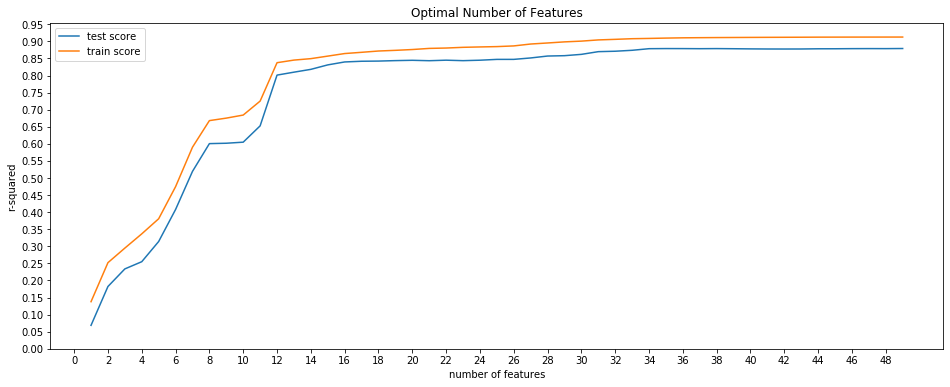

In [300]:
# Plot for test and train
# Clearly 13 variable are enough
plt.figure(figsize=(16,6))

plt.plot(cv_results.param_n_features_to_select, cv_results.mean_test_score)
plt.plot(cv_results.param_n_features_to_select, cv_results.mean_train_score)
plt.xlabel('number of features')
plt.xticks(np.arange(0,50,2))
plt.ylabel('r-squared')
plt.yticks(np.arange(0,1,0.05))
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [301]:
# RFE on model
n_features_optimal= 13
lm_new= LinearRegression()
rfe_new= RFE(lm_new, n_features_to_select= n_features_optimal)
rfe_new.fit(X_train_cv, y_train_cv)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=13, step=1, verbose=0)

In [302]:

y_pred_cv= rfe_new.predict(X_test_cv)
r2 = sklearn.metrics.r2_score(y_test_cv, y_pred_cv)
print(r2)

0.8374968837606342


In [303]:
# inverse transform to price
Y_pred= y_scaler_cv.inverse_transform(y_pred_cv.reshape(-1,1))
Y_pred=[float(x) for x in list(Y_pred)]

Y_test= y_scaler_cv.inverse_transform(y_test_cv)
Y_test=[float(x) for x in list(Y_test)]

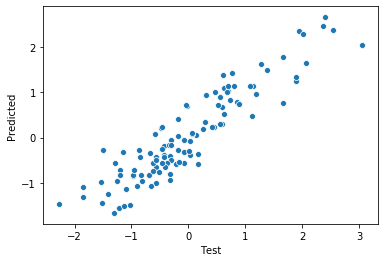

In [305]:
# Scaled plot
plt.xlabel('Test')
plt.ylabel('Predicted')
sns.scatterplot(x= [float(j) for j in list(y_test_cv)] , y= y_pred_cv )

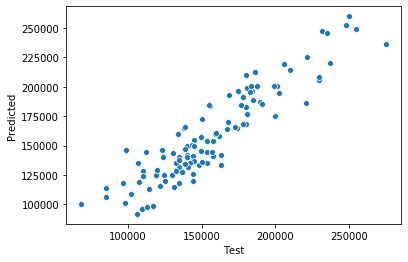

In [306]:
# Unscaled plot
plt.xlabel('Test')
plt.ylabel('Predicted')
sns.scatterplot(x= Y_test , y= Y_pred )

In [307]:
# r squared
sklearn.metrics.r2_score(Y_test, Y_pred)

0.8374968837606342

In [308]:
rfe_new.estimator_.coef_

array([ 0.54344947,  0.68402146,  0.86200637,  0.57319506, -0.55520096,
       -0.61319707, -0.75818705, -0.9363638 , -0.91241787, -1.17282889,
       -1.30259735,  0.80987686, -0.45983317])

In [309]:
model_columns= X_train_cv.columns.values[rfe_new.support_]

In [310]:
# the required columns
model_columns

array(['GrLivArea', 'Neighborhood_Crawfor', 'Neighborhood_NridgHt',
       'Neighborhood_Somerst', 'Building_Age_bin_(30, 40)',
       'Building_Age_bin_(40, 50)', 'Building_Age_bin_(50, 60)',
       'Building_Age_bin_(60, 70)', 'Building_Age_bin_(70, 80)',
       'Building_Age_bin_(80, 90)', 'Building_Age_bin_(90, 100)',
       'GarageCars_3', 'MSSubClass_50'], dtype=object)

# Stats Models

In [311]:
model_sm= model

In [312]:
X_scaler_sm= StandardScaler()
y_scaler_sm= StandardScaler()

In [313]:
y_sm= model_sm['SalePrice']
X_sm= model_sm[model_columns]

In [314]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm= train_test_split(X_sm, y_sm, train_size= 0.8, test_size= 0.2, random_state= 600 )

In [315]:
numerical_columns_sm= [x for x in Numerical if (x in model_columns)]

In [316]:
numerical_columns_sm

['GrLivArea']

In [317]:
X_train_sm[numerical_columns_sm]= X_scaler_sm.fit_transform(X_train_sm[numerical_columns_sm])

In [318]:
X_test_sm[numerical_columns_sm]= X_scaler_sm.transform(X_test_sm[numerical_columns_sm])

In [319]:
y_train_sm= y_scaler_sm.fit_transform(y_train_sm.values.reshape(-1,1))

In [320]:
y_test_sm= y_scaler_sm.transform(y_test_sm.values.reshape(-1,1))

In [321]:
X_train_sm= sm.add_constant(X_train_sm)

In [322]:
sm_model= sm.OLS(y_train_sm,X_train_sm).fit()

In [323]:
sm_model.summary()
# all pvals are acceptable

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     171.5
Date:                Mon, 27 Jul 2020   Prob (F-statistic):          1.17e-160
Time:                        23:46:58   Log-Likelihood:                -224.58
No. Observations:                 443   AIC:                             477.2
Df Residuals:                     429   BIC:                             534.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.4968      0.038     12.998      0.000       0.422       0.572
GrLivArea                      0.5204      0.024     22.051      0.000       0.474       0.567
Neighborhood_Crawfor           0.8685      0.194      4.481      0.000       0.488       1.249
Neighborhood_NridgHt           0.8391      0.213      3.934      0.000       0.420       1.258
Neighborhood_Somerst           0.4417      0.107      4.147      0.000       0.232       0.651
Building_Age_bin_(30, 40)     -0.5391      0.067     -8.106      0.000      -0.670      -0.408
Building_Age_bin_(40, 50)     -0.6463      0.062    -10.418      0.000      -0.768      -0.524
Building_Age_bin_(50, 60)     -0.8086      0.066    -12.255      0.000      -0.938      -0.679
Building_Age_bin_(60, 70)     -0.9150      0.100     -9.151      0.000      -1.111      -0.718
Building_Age_bin_(70, 80)     -0.9386      0.126     -7.430      0.000      -1.187      -0.690
Building_Age_bin_(80, 90)     -1.1983      0.107    -11.171      0.000      -1.409      -0.987
Building_Age_bin_(90, 100)    -1.4027      0.145     -9.648      0.000      -1.689      -1.117
GarageCars_3                   0.8911      0.114      7.839      0.000       0.668       1.114
MSSubClass_50                 -0.4216      0.080     -5.252      0.000      -0.579      -0.264
==============================================================================
Omnibus:                        6.009   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                7.963
Skew:                           0.090   Prob(JB):                       0.0187
Kurtosis:                       3.632   Cond. No.                         11.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [324]:
# variance_inflation_factor()
# Clearly the vif for all are also below 5

columns_vif= X_train_sm.columns
vif= [variance_inflation_factor(X_train_sm.values, x[0]) for x in list(enumerate(columns_vif)) ]
VIF= pd.DataFrame({'var_names': columns_vif, 'VIF': vif}, index= range(1, (len(columns_vif) + 1)))
VIF.sort_values(by= 'VIF', ascending= False, inplace= True)
VIF

,var_names,VIF
1,const,3.884034
14,MSSubClass_50,1.977842
9,"Building_Age_bin_(60, 70)",1.625806
8,"Building_Age_bin_(50, 60)",1.610209
10,"Building_Age_bin_(70, 80)",1.565457
11,"Building_Age_bin_(80, 90)",1.505613
7,"Building_Age_bin_(40, 50)",1.484135
2,GrLivArea,1.480300
12,"Building_Age_bin_(90, 100)",1.360651
6,"Building_Age_bin_(30, 40)",1.318095


#  Ridge Regression


In [325]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge= Ridge()


In [326]:
y_rd= model['SalePrice']
X_rd= model[no_sale_price]

In [327]:
X_train_rd, X_test_rd, y_train_rd, y_test_rd= train_test_split(X_rd, y_rd, train_size= 0.8, test_size= 0.2, random_state= 200 )

In [328]:
model_cv_rd = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv_rd.fit(X_train_rd, y_train_rd) 

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.9s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=500, shuffle=True),
             error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [329]:
cv_results_rd = pd.DataFrame(model_cv_rd.cv_results_)
cv_results_rd = cv_results_rd[cv_results_rd['param_alpha']<=200]
cv_results_rd.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.002393,1.196854e-03,0.000699,0.000457,0.0001,{'alpha': 0.0001},-10034.514857,-11248.561978,-10046.710619,-9445.447166,...,-9202.376946,-9283.599797,-9218.165636,-9223.993328,-9002.209031,-8998.008109,-8783.327769,-9286.579355,-9124.603940,151.466267
1,0.001994,8.675292e-07,0.000599,0.000489,0.001,{'alpha': 0.001},-10035.099493,-11248.130646,-10046.543027,-9443.820378,...,-9202.230610,-9283.498794,-9218.123868,-9223.836329,-9002.101618,-8997.812704,-8783.233468,-9286.464304,-9124.478016,151.468914
2,0.001995,7.728785e-04,0.000798,0.000399,0.01,{'alpha': 0.01},-10040.903948,-11243.880440,-10044.842599,-9427.684043,...,-9200.789765,-9282.503176,-9217.758679,-9222.327143,-9001.048962,-8995.884894,-8782.302392,-9285.329316,-9123.244597,151.500911
3,0.001895,2.994304e-04,0.000599,0.000489,0.05,{'alpha': 0.05},-10065.798966,-11226.985939,-10036.818692,-9358.694892,...,-9195.149472,-9278.917396,-9216.775450,-9219.303376,-8997.702289,-8988.842842,-8778.402502,-9281.500866,-9118.909262,151.918142
4,0.001695,4.571163e-04,0.000698,0.000457,0.1,{'alpha': 0.1},-10094.934952,-11209.714632,-10025.983688,-9278.067463,...,-9191.787533,-9275.285040,-9216.249352,-9216.664713,-8997.066422,-8981.351297,-8774.364724,-9279.112628,-9115.228709,152.542680


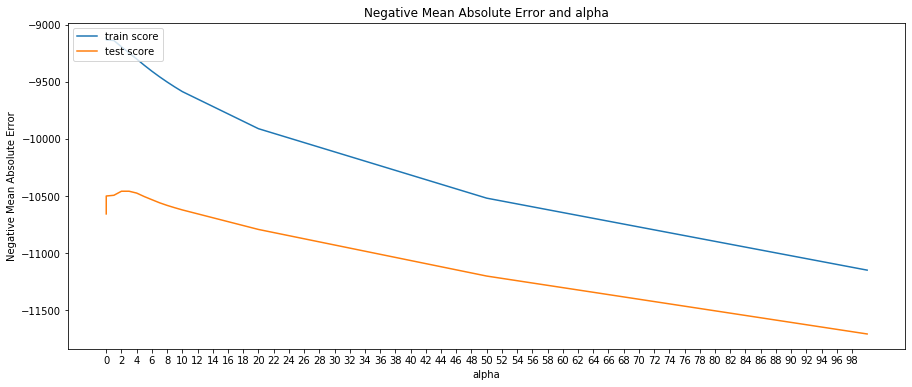

In [330]:
# plotting mean test and train scoes with alpha 
plt.figure(figsize= (15,6))

cv_results_rd['param_alpha'] = cv_results_rd['param_alpha'].astype('int32')


plt.plot(cv_results_rd['param_alpha'], cv_results_rd['mean_train_score'])
plt.plot(cv_results_rd['param_alpha'], cv_results_rd['mean_test_score'])
plt.xlabel('alpha')
plt.xticks(np.arange(0,100,2))
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [331]:
# 5 is an acceptable value for alpha for ridge regression
alpha = 5
ridge = Ridge(alpha=alpha)

ridge.fit(X_train_rd, y_train_rd)
ridge.coef_

array([-2.09777607e+03,  4.61934117e+03,  3.18987685e+01, -1.59696988e+01,
        3.59709233e+01,  2.21123007e+03,  3.73964675e+03,  6.85306179e+02,
       -1.09079061e+01,  3.50951539e+01,  6.50833382e+02,  7.65703683e+03,
       -3.08758008e+03, -3.00106974e+03, -6.34184116e+03, -6.39354926e+02,
       -3.05974740e+03,  1.82203566e+03,  7.82429349e+03, -6.00370277e+03,
       -3.54527405e+03, -4.83577676e+03,  9.77802849e+03, -1.90324897e+03,
       -2.97644823e+03, -8.82368916e+03,  6.20274558e+03,  1.39454047e+04,
        2.14810042e+03,  2.18834021e+03, -2.36354650e+03,  1.12622999e+03,
       -2.78727768e+03, -1.52476621e+03, -3.88048606e+03, -6.76523696e+03,
       -6.17658327e+03, -1.66466584e+03,  2.02016275e+03,  4.64092958e+03,
        2.09218073e+03, -1.57981786e+03, -2.81843243e+02,  1.49244624e+03,
        1.52007298e+03,  1.86947290e+03, -2.62831814e+03, -6.31127405e+03,
       -9.80737299e+02, -2.89971718e+03,  9.09251885e+03, -9.99656496e+03,
       -1.32384543e+04,  

# Lasso

In [332]:

y_ls= model['SalePrice']
X_ls= model[no_sale_price]


In [333]:
X_train_ls, X_test_ls, y_train_ls, y_test_ls= train_test_split(X_ls, y_ls, train_size= 0.8, test_size= 0.2, random_state= 50 )

In [334]:
lasso = Lasso()

In [335]:


# cross validation
model_cv_ls = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv_ls.fit(X_train_ls, y_train_ls) 

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    2.7s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=500, shuffle=True),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [336]:
cv_results_ls = pd.DataFrame(model_cv_ls.cv_results_)
#cv_results_ls = cv_results_ls[cv_results_ls['param_alpha']<=10]
cv_results_ls.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.015957,0.001839,0.000798,0.000399,0.0001,{'alpha': 0.0001},-10038.889134,-10379.482511,-11698.921348,-10226.568172,...,-8720.934501,-8932.670828,-8997.904131,-8763.402995,-9030.601127,-8930.195217,-8993.058886,-8782.473529,-8914.715815,109.212307
1,0.014063,0.002541,0.000898,0.000299,0.001,{'alpha': 0.001},-10038.882321,-10379.463840,-11698.932597,-10226.542363,...,-8720.932730,-8932.671845,-8997.901486,-8763.402434,-9030.601755,-8930.194202,-8993.062711,-8782.468806,-8914.715178,109.213280
2,0.012367,0.002054,0.000698,0.000457,0.01,{'alpha': 0.01},-10038.814190,-10379.277129,-11699.045096,-10226.284270,...,-8720.915016,-8932.682014,-8997.875034,-8763.396821,-9030.608035,-8930.184055,-8993.100955,-8782.421575,-8914.708805,109.223019
3,0.011469,0.002196,0.000598,0.000489,0.05,{'alpha': 0.05},-10038.511383,-10378.447304,-11699.545090,-10225.137188,...,-8720.836289,-8932.727207,-8997.757467,-8763.371874,-9030.636009,-8930.138954,-8993.270932,-8782.211659,-8914.680487,109.266356
4,0.010871,0.002294,0.000798,0.000399,0.1,{'alpha': 0.1},-10038.132893,-10377.410015,-11700.170083,-10223.703336,...,-8720.737880,-8932.783699,-8997.610508,-8763.340690,-9030.670996,-8930.082578,-8993.483402,-8781.949260,-8914.645092,109.320638


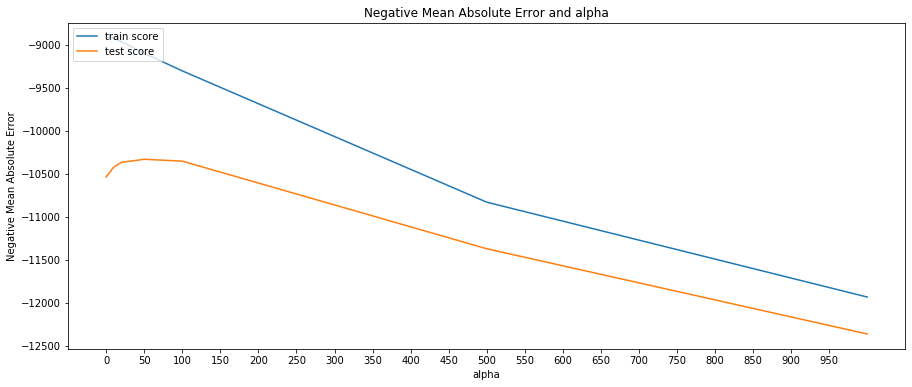

In [337]:
# plotting for alpha test and train
cv_results_ls['param_alpha'] = cv_results_ls['param_alpha'].astype('int32')
plt.figure(figsize= (15,6))

plt.plot(cv_results_ls['param_alpha'], cv_results_ls['mean_train_score'])
plt.plot(cv_results_ls['param_alpha'], cv_results_ls['mean_test_score'])
plt.xticks(np.arange(0,1000,50))
plt.xlabel('alpha')

plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [338]:
# 50 is an acceptable value for alpha
alpha =50

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train_ls, y_train_ls) 

Lasso(alpha=50, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [339]:
lasso.coef_

array([   821.90664884,   2293.75304154,     30.90572208,    -18.61636411,
           39.2659396 ,    857.82588809,   3748.65464155,   1624.9265374 ,
           41.19817626,     25.91149357,   3856.80415218,   1871.18342802,
        -4452.35563606,  -1924.89923064,      0.        ,     -0.        ,
        -2957.68847559,   3049.60336815,  13600.55019335,  -5186.17519539,
        -1970.80451323,   -644.02138344,  13878.95057798,     -0.        ,
        -2754.48980639,  -7508.92753709,   7372.1864018 ,  18187.59177454,
         1472.36491725,    858.73965821,  -1387.18578612,      0.        ,
        -3263.63333233,      0.        ,   -188.90529619,  -2211.92606621,
        -7039.57473784,     -0.        ,   4190.26886613,   3220.49433113,
          362.60455171,  -2444.30287113,     -0.        ,   1338.60956037,
         2838.72725375,    998.78590595,  -4234.6552908 ,  -7463.56921592,
           -0.        ,     -0.        ,  12529.3654237 , -15367.94549032,
       -14983.91491691,  